# 1. Initialization

## Importing Required Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam, AdamW, SGD, RMSprop, Adadelta
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader

import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn import metrics
import seaborn as sns
from tqdm.notebook import tqdm
import pickle
# from fitter import Fitter, get_common_distributions, get_distributions
# from pymoo.optimize import minimize
# from pymoo.core.problem import Problem
# from pymoo.algorithms.moo.nsga2 import NSGA2

## Primary Setting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Path = "/content/drive/MyDrive/Thesis/MI-LSTM-GA"
Path1 = "/content/drive/MyDrive/Thesis_Preliminary"
Path2 = "/content/drive/MyDrive/Thesis"
Path3 = "/content/drive/MyDrive/Thesis_Secondary"
SA_Path = "/content/drive/MyDrive/Thesis/SA"

from google.colab import output
output.enable_custom_widget_manager()

Mounted at /content/drive


## Required Functions and Classes


In [ ]:
def train_val_test(Data_Frame, Val_Ratio, Test_Ratio, Seq_Length):

    train_ratio = 1 - (Val_Ratio + Test_Ratio)
    trainval_ratio = 1 - Test_Ratio
    data_size = len(Data_Frame)

    separator_1 = np.floor(data_size * train_ratio).astype(int)
    separator_2 = np.floor(data_size * trainval_ratio).astype(int)

    train = Data_Frame[:separator_1]
    validation = Data_Frame[separator_1 - Seq_Length + 1:separator_2]
    train_val = Data_Frame[:separator_2]
    test = Data_Frame[separator_2 - Seq_Length + 1:]

    return train, validation, train_val, test

# ---------------------------------------------------------------------------- #

def List_Maker(List, Indices):
    New_List = []
    for i in Indices:
        New_List.append(List[i])
    return New_List

# ---------------------------------------------------------------------------- #

def df_scaler(Data_Frame, Scaler):
    new_df = pd.DataFrame(
        Scaler.transform(Data_Frame),
        columns = Data_Frame.columns
    )
    return new_df

# ---------------------------------------------------------------------------- #

def Sequence_Maker(Input: pd.DataFrame, Target_Labels, Seq_Length):
    sequences = []
    input_size = len(Input)

    for i in range(input_size - Seq_Length):
        sequence = Input.iloc[i:i+Seq_Length]
        label_index = i + Seq_Length
        labels = Input.loc[label_index, Target_Labels]

        sequences.append((sequence, labels))

    return sequences

# ---------------------------------------------------------------------------- #

def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

# ---------------------------------------------------------------------------- #

def Save(Input, File_Name, Type, Dir=Path):
    # print(Dir)
    full_name = f"{File_Name}.{Type}"

    if Type == "npy":
        np.save(full_name, Input)
        !cp "{full_name}" "{Dir}"

    elif Type == "csv":
        Input.to_csv(full_name)
        !cp "{full_name}" "{Dir}"
    
    elif Type == "xlsx":
        Input.to_excel(full_name)
        !cp "{full_name}" "{Dir}"
    
    elif Type == "pkl":
        pickle.dump(Input, open(full_name, 'wb'))
        !cp "{full_name}" "{Dir}"

    else:
        print("ERROR: Something goes wrong! Check the storage type.")

# ---------------------------------------------------------------------------- #

def Load(File_Name, Type, Dir=Path):
    # print(Dir)
    full_name = f"{File_Name}.{Type}"

    if Type == "npy":
        path = f"{Dir}/{full_name}"
        return np.load(path)
    
    elif Type == "xlsx":
        path = f"{Dir}/{full_name}"
        return pd.read_excel(path).drop(["Unnamed: 0"], axis=1)
    
    elif Type == "csv":
        path = f"{Dir}/{full_name}"
        return pd.read_csv(path).drop(["Unnamed: 0"], axis=1)
    
    elif Type == "pkl":
        path = f"{Dir}/{full_name}"
        return pickle.load(open(path, 'rb'))
    
    else:
        print("ERROR: Something goes wrong! Check the file's format.")

# ---------------------------------------------------------------------------- #

def Grids(Num_Hiddens, Num_Layers, Batch_Sizes, Sequence_Lengths, Optimizers, Learning_Rates):
    
    HyperParametersList = []
    counter = 0
    for a in range(len(Num_Hiddens)):
        for b in range(len(Num_Layers)):
            for c in range(len(Batch_Sizes)):
                for d in range(len(Sequence_Lengths)):
                    for e in range(len(Optimizers)):
                        for f in range(len(Learning_Rates)):

                            HP = {
                                'num_hidden' : Num_Hiddens[a],
                                'num_layers' : Num_Layers[b],
                                'num_batches' : Batch_Sizes[c],
                                'sequence_length' : Sequence_Lengths[d],
                                'optimizer' : Optimizers[e],
                                'learning_rate' : Learning_Rates[f],
                                'number' : counter
                            }

                            HyperParametersList.append(HP)
                            counter += 1
        
    return HyperParametersList

# ---------------------------------------------------------------------------- #

def Evaluate(labels, predictions):
    RMSE = metrics.mean_squared_error(y_true=labels, y_pred=predictions, squared=False)
    R2 = metrics.r2_score(y_true=labels, y_pred=predictions)
    MAE = metrics.mean_absolute_error(y_true=labels, y_pred=predictions)
    MAPE = metrics.mean_absolute_percentage_error(y_true=labels, y_pred=predictions)

    print("---------- Evaluation Results ----------\n")
    print(f"RMSE is:   {RMSE:.3f}")
    print(f"MAE is:   {MAE:.3f}")
    print(f"MAPE is:   {MAPE:.3f}")
    print(f"R-squared is:   {R2:.3f}")

# ---------------------------------------------------------------------------- #

def AR2(Num_Features, Num_Rows, labels, predictions):
    R2 = metrics.r2_score(y_true=labels, y_pred=predictions)
    AR2 = 1 - ((1 - R2) * (Num_Rows - 1) / (Num_Rows - Num_Features - 1))
    
    print(f"Adjusted R-squared is:   {AR2:.3f}")

# ---------------------------------------------------------------------------- #

class Dataset(Dataset):

    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]

        return dict(
            sequence = torch.Tensor(sequence.to_numpy()),
            label = torch.tensor(label).float()
        )

# ---------------------------------------------------------------------------- #

class LSTM(nn.Module):

    def __init__(self, num_input, num_hidden=32, num_output=1, num_layers=2):
        super(LSTM, self).__init__()

        self.num_input = num_input
        self.num_hidden = num_hidden
        self.num_output = num_output
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size = num_input,
            hidden_size = num_hidden,
            num_layers = num_layers,
            batch_first = True,
            dropout = 0.2
        )

        self.fc = nn.Linear(num_hidden, num_output)
    
    def forward(self, batch):
        self.lstm.flatten_parameters()

        h0 = torch.zeros(self.num_layers, batch.size(0), self.num_hidden)
        c0 = torch.zeros(self.num_layers, batch.size(0), self.num_hidden)

        _, (hidden, _) = self.lstm(batch, (h0, c0))

        out = hidden[-1]

        out = self.fc(out)

        return out.squeeze(dim=1)

# ---------------------------------------------------------------------------- #

def Return_Column_Position(DF, Col_Name):
    p = -1
    for i in range(len(DF.columns)):
        if DF.columns[i] == Col_Name:
            p = i
    
    if p != -1:
        return p
    else:
        print(f"There is no {Col_Name} in the DataFrame columns!")

# 2. Data Loading

In [ ]:
df = Load("SD_Retro", "xlsx", Dir=Path1).loc[28:]
data = Load("SD_Retro", "xlsx", Dir=Path1)

print(df.shape)

(1950, 19)


# 3. Modeling

## Model Configuration

In [ ]:
hiddens = [32, 64, 128, 256]
layers = [2, 4]
batches = [32, 64, 128]
seq_lens = [30, 60, 90, 120]
optimizers = [Adam]
LRs = [0.001]

Dict_List = Grids(hiddens, layers, batches, seq_lens, optimizers, LRs)
len(Dict_List)

96

## 3.1 TSS Out

### Feature Selection
In this section, optimal features will be selected by **Mutual Information** method.

In [ ]:
num_features = 7

features = df.drop("TSS_out", axis=1)
labels = df.loc[:, "TSS_out"]
TSS_mutual_list = []

trf1, tsf1, trl1, tsl1 = train_test_split(features, labels, test_size=0.2, shuffle=False)

mutual_info = mutual_info_regression(trf1, trl1)
mutual_info = pd.Series(mutual_info)
mutual_info.index = trf1.columns
mutual_info = mutual_info.sort_values(ascending=False)

for i in range(num_features):
    TSS_mutual_list.append(mutual_info.index[i])

TSS_mutual_list

['COD_out', 'BOD_out', 'TN_in', 'MLSS', 'SV', 'RS_MLSS', 'SVI']

In [ ]:
mutual_info

COD_out     2.318106
BOD_out     2.103569
TN_in       1.456329
MLSS        1.429558
SV          1.415443
RS_MLSS     1.364220
SVI         1.354555
TSS_in      1.215124
O2_D_avg    1.208937
TP_out      1.184316
RS_SV       1.133094
O2_C_avg    1.126606
BOD_in      1.092718
O2_A_avg    1.077208
COD_in      1.040780
TP_in       1.038079
O2_B_avg    0.998843
TN_out      0.978255
dtype: float64

In [ ]:
# TSS_list = TSS_mutual_list + ['TSS_out']
# TSS_Data = df.loc[:, TSS_list]
# TSS_Data

# Save(TSS_Data, "TSS_Data", "xlsx")

### Model Selection

*   **Training**
*   **Validation**
*   **Comparison:** based on MSE Loss



In [ ]:
# TSS_Comb_Loss_MLS = np.zeros(shape=(len(Dict_List),))
# Save(TSS_Comb_Loss_MLS, "TSS_Comb_Loss_MLS", "npy", Path)

Model selection with whole candidates.

In [ ]:
TSS_Data = Load("TSS_Data", "xlsx")

# contain the final loss of each combination
TSS_Comb_Loss_MLS = Load("TSS_Comb_Loss_MLS", "npy", Path)

# set target and its index
target = 'TSS_out'
target_index = Return_Column_Position(TSS_Data, "TSS_out")

# set parameters
input_size = len(TSS_Data.iloc[0])
output_size = 1
val_ratio = 0.1
test_ratio = 0.2

n_epoch = 200

patience = 5
scheduler_patience = 3

best_val_loss_TSS = np.inf

for combination in tqdm(Dict_List):
    no_imp = 0
    
    # unpacking parameters 
    Sequence_Length = combination['sequence_length']
    Batch_Size = combination['num_batches']
    LR = combination['learning_rate']
    Hidden_Size = combination['num_hidden']
    Layers = combination['num_layers']
    Comb_Numb = combination['number']

    # separating dataframes
    train_df, val_df, train_val_df, test_df = train_val_test(TSS_Data, val_ratio, test_ratio, Sequence_Length)

    # scaling data into -1 and 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_val_df)
    train_df = df_scaler(train_df, scaler)
    val_df = df_scaler(val_df, scaler)
    test_df = df_scaler(test_df, scaler)

    # making sequences
    train_sequences = Sequence_Maker(train_df, target, Sequence_Length)
    val_sequences = Sequence_Maker(val_df, target, Sequence_Length)
    test_sequences = Sequence_Maker(test_df, target, Sequence_Length)

    # making datasets
    train_dataset = Dataset(train_sequences)
    val_dataset = Dataset(val_sequences)
    test_dataset = Dataset(test_sequences)

    # making dataloaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=Batch_Size, shuffle=False, num_workers=2)
    val_loader = DataLoader(dataset=val_dataset, batch_size=Batch_Size, shuffle=False, num_workers=1)
    test_loader = DataLoader(dataset=test_dataset, batch_size=Batch_Size, shuffle=False, num_workers=1)

    # making the model
    model = LSTM(
        num_input=input_size,
        num_hidden=Hidden_Size,
        num_output=output_size,
        num_layers=Layers
    )


    # set criterion and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)
    scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=scheduler_patience)


    # Training Process
    val_loss_min = np.inf

    for epoch in range(n_epoch):

        # LR_old = optimizer.state_dict()["param_groups"][0]["lr"]
        # print(f"     ----- Epoch {epoch+1} -----    \n")
        training_loss = 0
        iter = 1
        model.train()

        # print("Trainig ...")
        for item in train_loader:

            features = item["sequence"]
            labels = item["label"]

            outputs = model(features)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            training_loss += loss.item() * features.shape[0]

            iter += 1

        training_loss = training_loss / len(train_loader.sampler)

        # training_loss_list.append(training_loss)

        # print (f'Training loss: {training_loss:.6f}\n')

        is_training = model.training
        val_loss = 0
        model.eval()

        # print("Validation ...")
        for val_item in val_loader:

            val_features = item["sequence"]
            val_labels = item["label"]

            val_output = model(val_features)

            vloss = criterion(val_output, val_labels)

            val_loss += vloss

        val_loss += val_loss / len(val_loader.sampler)

        # validation_loss_list.append(val_loss)
        if val_loss <= val_loss_min:
            # print(f"Validation loss decreased: {val_loss_min:.6f} ------> {val_loss:.6f}")
            # print(f"model saved ...\n")
            torch.save(model.state_dict(), 'model_TSS.pt')
            best_params = model.state_dict()
            val_loss_min = val_loss
            no_imp = 0
        else:
            no_imp += 1
            # print(f"Validation loss: {val_loss:.6f}")
            # print(f"No improvements in this epoch!!!\n")

        if no_imp == patience:
            # print("\nEarly Stopping ...")
            break

        scheduler.step(val_loss)
        # LR_new = optimizer.state_dict()["param_groups"][0]["lr"]
        # if LR_new != LR_old:
        #     print(f"Learning rate changed from {LR_old} to {LR_new}.\n\n")

        model.train(mode=is_training)

    # print(f"Minimum loss is: {val_loss_min:.6f}")

    if val_loss_min <= best_val_loss_TSS:
        best_val_loss_TSS = val_loss_min
        best_params_all_TSS = best_params
        torch.save(best_params_all_TSS, "best_params_TSS.pt")
        best_comb_TSS = combination
        best_scaler_TSS = scaler
        best_model_TSS = model

    TSS_Comb_Loss_MLS[Comb_Numb] = val_loss_min

    if Comb_Numb>0:
        if Comb_Numb % 10 == 0:
            Save(TSS_Comb_Loss_MLS, "TSS_Comb_Loss_MLS", "npy", Dir=Path)

    print(f"combination {Comb_Numb}  --->  loss: {val_loss_min:.6f}  --->  minimum loss so far: {best_val_loss_TSS:.6f}")

print("\n\n---------------   Final Results   ---------------\n")
print(f"Minimum Loss: {best_val_loss_TSS:.6f}")

Save(best_model_TSS, "Best_Model_TSS", "pkl", Dir=Path)
Save(best_comb_TSS, "Best_Comb_TSS", "pkl", Dir=Path)
Save(best_scaler_TSS, "Best_Scaler_TSS", "pkl", Dir=Path)
Save(best_params_all_TSS, "Best_Params_All_TSS", "pkl", Dir=Path)
Save(TSS_Comb_Loss_MLS, "TSS_Comb_Loss_MLS", "npy", Dir=Path)

  0%|          | 0/96 [00:00<?, ?it/s]

combination 0  --->  loss: 0.002986  --->  minimum loss so far: 0.002986
combination 1  --->  loss: 0.002832  --->  minimum loss so far: 0.002832
combination 2  --->  loss: 0.005391  --->  minimum loss so far: 0.002832
combination 3  --->  loss: 0.005651  --->  minimum loss so far: 0.002832
combination 4  --->  loss: 0.015055  --->  minimum loss so far: 0.002832
combination 5  --->  loss: 0.013443  --->  minimum loss so far: 0.002832
combination 6  --->  loss: 0.016674  --->  minimum loss so far: 0.002832
combination 7  --->  loss: 0.004061  --->  minimum loss so far: 0.002832
combination 8  --->  loss: 0.007968  --->  minimum loss so far: 0.002832
combination 9  --->  loss: 0.001947  --->  minimum loss so far: 0.001947
combination 10  --->  loss: 0.004560  --->  minimum loss so far: 0.001947
combination 11  --->  loss: 0.006265  --->  minimum loss so far: 0.001947
combination 12  --->  loss: 0.005382  --->  minimum loss so far: 0.001947
combination 13  --->  loss: 0.004650  --->  mini

Storing the top 10 models.

In [ ]:
TSS_Comb_Loss_MLS = Load("TSS_Comb_Loss_MLS", "npy", Path)
TSS_Comb_Sorted = np.sort(TSS_Comb_Loss_MLS)
TSS_Comb_Argsorted = np.argsort(TSS_Comb_Loss_MLS)

N_Top = 10
TSS_Top_Comb_MLS = []
for i in range(N_Top):
    TSS_Top_Comb_MLS.append(Dict_List[TSS_Comb_Argsorted[i]])

# best_comb_TSS = TSS_Top_Comb_MLS[0]
# Save(best_comb_TSS, "Best_Comb_TSS", "pkl", Path)

# Save(TSS_Top_Comb_MLS, "TSS_Top_Comb_MLS", "pkl", Path)

### Trainig Process of the Best Model

*   **Trainig**
*   **Validation**
*   **Learning Plot:** Training Loss vs. Validation Loss 



In [ ]:
TSS_Data = Load("TSS_Data", "xlsx", Path)

# set target and its index
target = 'TSS_out'
target_index = Return_Column_Position(TSS_Data, 'TSS_out')

# set parameters
input_size = len(TSS_Data.iloc[0])
output_size = 1
val_ratio = 0.1
test_ratio = 0.2

n_epoch = 500

no_imp = 0

patience = 16
scheduler_patience = 5
scheduler_factor = 0.1

# contain the values of training and validation losses
TSS_Train_Loss = np.zeros(shape=(n_epoch,))
TSS_Valid_Loss = np.zeros(shape=(n_epoch,))

best_comb_TSS = Load("Best_Comb_TSS", "pkl", Path)
Sequence_Length = best_comb_TSS['sequence_length']
Batch_Size = best_comb_TSS['num_batches']
Hidden_Size = best_comb_TSS['num_hidden']
Layers = best_comb_TSS['num_layers']
# LR = best_comb_TSS['learning_rate']
LR = 0.0001

# separating dataframes
train_df, val_df, train_val_df, test_df = train_val_test(TSS_Data, val_ratio, test_ratio, Sequence_Length)

# scaling data into -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_val_df)
train_df = df_scaler(train_df, scaler)
val_df = df_scaler(val_df, scaler)
test_df = df_scaler(test_df, scaler)

# making sequences
train_sequences = Sequence_Maker(train_df, target, Sequence_Length)
val_sequences = Sequence_Maker(val_df, target, Sequence_Length)
test_sequences = Sequence_Maker(test_df, target, Sequence_Length)

# making datasets
train_dataset = Dataset(train_sequences)
val_dataset = Dataset(val_sequences)
test_dataset = Dataset(test_sequences)

# making dataloaders
train_loader = DataLoader(dataset=train_dataset, batch_size=Batch_Size, shuffle=False, num_workers=2)
val_loader = DataLoader(dataset=val_dataset, batch_size=Batch_Size, shuffle=False, num_workers=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=Batch_Size, shuffle=False)

# making the model
model = LSTM(num_input=input_size, num_hidden=Hidden_Size, num_output=output_size, num_layers=Layers)


# set criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=scheduler_factor, patience=scheduler_patience)


# Training Process
val_loss_min = np.inf
for epoch in range(n_epoch):
    LR_old = optimizer.state_dict()["param_groups"][0]["lr"]
    print(f"     ----- Epoch {epoch+1} -----    \n")
    training_loss = 0
    iter = 1
    model.train()

    print("Trainig ...")
    for item in tqdm(train_loader):

        features = item["sequence"]
        labels = item["label"]

        outputs = model(features)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        training_loss += loss.item() * features.shape[0]

        iter += 1

    training_loss = training_loss / len(train_loader.sampler)
    TSS_Train_Loss[epoch] = training_loss

    print (f'Training loss: {training_loss:.6f}\n')

    is_training = model.training
    val_loss = 0
    model.eval()

    print("Validation ...")
    for val_item in tqdm(val_loader):

        val_features = item["sequence"]
        val_labels = item["label"]

        val_output = model(val_features)

        vloss = criterion(val_output, val_labels)

        val_loss += vloss

    val_loss += val_loss / len(val_loader.sampler)
    TSS_Valid_Loss[epoch] = val_loss

    # validation_loss_list.append(val_loss)

    if val_loss <= val_loss_min:
        print(f"Validation loss decreased: {val_loss_min:.6f} ------> {val_loss:.6f}")
        print(f"model saved ...\n")
        torch.save(model.state_dict(), 'model.pt')
        TSS_best_model_state_dict = model.state_dict()
        val_loss_min = val_loss
        Best_Model = model
        TSS_Best_Epoch = epoch
        no_imp = 0
    else:
        no_imp += 1
        print(f"Validation loss: {val_loss:.6f}")
        print(f"No improvements in this epoch!!!\n")

    if no_imp == patience:
        print("\nEarly Stopping ...")
        break

    scheduler.step(val_loss)
    LR_new = optimizer.state_dict()["param_groups"][0]["lr"]
    if LR_new != LR_old:
        print(f"Learning rate changed from {LR_old} to {LR_new}.\n\n")

    model.train(mode=is_training)

TSS_Final_Epoch = epoch
TSS_Epoch_Dict = {"Best":TSS_Best_Epoch, "Final":TSS_Final_Epoch}

print(f"Minimum loss is: {val_loss_min:.6f}")
Save(TSS_Train_Loss, "TSS_Train_Loss", "npy", Path)
Save(TSS_Valid_Loss, "TSS_Valid_Loss", "npy", Path)
Save(Best_Model, "Best_Model_TSS_Retrained", "pkl", Path)
Save(TSS_best_model_state_dict, "TSS_best_model_state_dict", "pkl", Path)
Save(TSS_Epoch_Dict, "TSS_Epoch_Dict", "pkl", Path)

     ----- Epoch 1 -----    

Trainig ...


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.354636

Validation ...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss decreased: inf ------> 0.149424
model saved ...

     ----- Epoch 2 -----    

Trainig ...


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.291445

Validation ...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss decreased: 0.149424 ------> 0.100535
model saved ...

     ----- Epoch 3 -----    

Trainig ...


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.232349

Validation ...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss decreased: 0.100535 ------> 0.055386
model saved ...

     ----- Epoch 4 -----    

Trainig ...


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.166163

Validation ...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss decreased: 0.055386 ------> 0.018762
model saved ...

     ----- Epoch 5 -----    

Trainig ...


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.109582

Validation ...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss decreased: 0.018762 ------> 0.008121
model saved ...

     ----- Epoch 6 -----    

Trainig ...


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.082558

Validation ...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss: 0.021239
No improvements in this epoch!!!

     ----- Epoch 7 -----    

Trainig ...


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.066393

Validation ...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss: 0.026258
No improvements in this epoch!!!

     ----- Epoch 8 -----    

Trainig ...


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.051713

Validation ...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss: 0.030047
No improvements in this epoch!!!

     ----- Epoch 9 -----    

Trainig ...


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.040719

Validation ...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss: 0.047518
No improvements in this epoch!!!

     ----- Epoch 10 -----    

Trainig ...


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.031008

Validation ...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss: 0.045671
No improvements in this epoch!!!

     ----- Epoch 11 -----    

Trainig ...


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.025953

Validation ...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss: 0.057766
No improvements in this epoch!!!

Learning rate changed from 0.0001 to 1e-05.


     ----- Epoch 12 -----    

Trainig ...


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.021644

Validation ...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss: 0.055527
No improvements in this epoch!!!

     ----- Epoch 13 -----    

Trainig ...


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.020972

Validation ...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss: 0.052545
No improvements in this epoch!!!

     ----- Epoch 14 -----    

Trainig ...


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.020357

Validation ...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss: 0.050220
No improvements in this epoch!!!

     ----- Epoch 15 -----    

Trainig ...


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.020017

Validation ...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss: 0.048728
No improvements in this epoch!!!

     ----- Epoch 16 -----    

Trainig ...


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.019799

Validation ...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss: 0.047775
No improvements in this epoch!!!

     ----- Epoch 17 -----    

Trainig ...


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.019447

Validation ...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss: 0.046949
No improvements in this epoch!!!

Learning rate changed from 1e-05 to 1.0000000000000002e-06.


     ----- Epoch 18 -----    

Trainig ...


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.019213

Validation ...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss: 0.046855
No improvements in this epoch!!!

     ----- Epoch 19 -----    

Trainig ...


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.019212

Validation ...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss: 0.046763
No improvements in this epoch!!!

     ----- Epoch 20 -----    

Trainig ...


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.019057

Validation ...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss: 0.046667
No improvements in this epoch!!!

     ----- Epoch 21 -----    

Trainig ...


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.019203

Validation ...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss: 0.046572
No improvements in this epoch!!!


Early Stopping ...
Minimum loss is: 0.008121


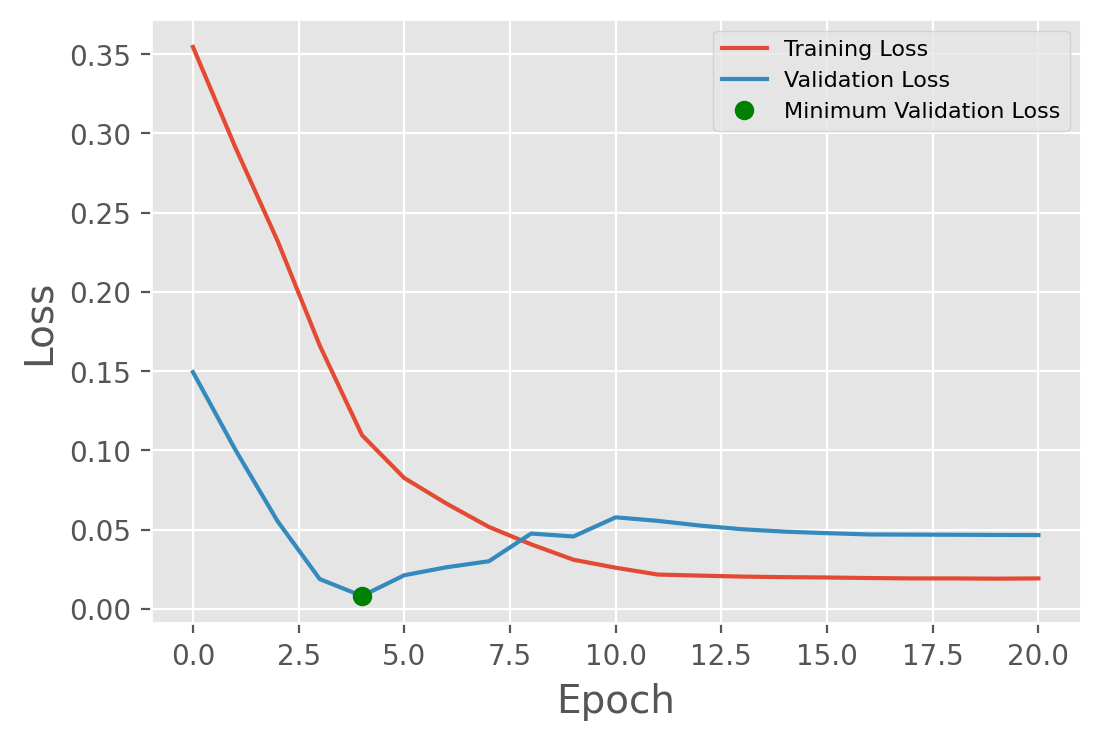

In [ ]:
TSS_Epoch_Dict = Load("TSS_Epoch_Dict", "pkl", Path)
TSS_Train_Loss = Load("TSS_Train_Loss", "npy", Path)
TSS_Valid_Loss = Load("TSS_Valid_Loss", "npy", Path)
Best_Epoch = TSS_Epoch_Dict["Best"]
Final_Epoch = TSS_Epoch_Dict["Final"]

num=np.arange(0, len(TSS_Valid_Loss[:Final_Epoch])+1)
plt.figure(dpi=200)
# plt.style.use('default')
plt.style.use('ggplot')
plt.plot(num, TSS_Train_Loss[:Final_Epoch+1], linewidth=1.5, label="Training Loss")
plt.plot(num, TSS_Valid_Loss[:Final_Epoch+1], linewidth=1.5, label="Validation Loss")
plt.plot(Best_Epoch, TSS_Valid_Loss[Best_Epoch], "go", linewidth=0.5, label="Minimum Validation Loss")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(prop={'size': 8})
plt.show()

In [ ]:
print("Best Epoch:", Best_Epoch+1)
print("Final Epoch:", Final_Epoch+1)
print("Training Loss:", TSS_Train_Loss[Best_Epoch])
print("Validation Loss:", TSS_Valid_Loss[Best_Epoch])

Best Epoch: 5
Final Epoch: 21
Training Loss: 0.10958181868407205
Validation Loss: 0.008121481165289879


### Model Evaluation
Evaluation will be performed on test dataset based on following error functions:

*   $RMSE$
*   $MAE$
*   $MAPE$
*   $R^2$



**Smoothed Data**

In [ ]:
TSS_Data = Load("TSS_Data", "xlsx")

target = 'TSS_out'
target_index = Return_Column_Position(TSS_Data, 'TSS_out')

input_size = len(TSS_Data.iloc[0])
output_size = 1
val_ratio = 0.1
test_ratio = 0.2

best_comb_TSS = Load("Best_Comb_TSS", "pkl", Path)
Sequence_Length = best_comb_TSS['sequence_length']
Batch_Size = best_comb_TSS['num_batches']
Hidden_Size = best_comb_TSS['num_hidden']
Layers = best_comb_TSS['num_layers']
LR = best_comb_TSS['learning_rate']

# separating dataframes
train_df, val_df, train_val_df, test_df = train_val_test(TSS_Data, val_ratio, test_ratio, Sequence_Length)

# scaling data into -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_val_df)
test_df = df_scaler(test_df, scaler)

# making sequences
test_sequences = Sequence_Maker(test_df, target, Sequence_Length)

# making datasets
test_dataset = Dataset(test_sequences)

# making dataloaders
test_loader = DataLoader(dataset=test_dataset, batch_size=Batch_Size, shuffle=False, num_workers=1)

best_scaler_TSS = Load("Best_Scaler_TSS", "pkl")

target_index = Return_Column_Position(TSS_Data, "TSS_out")

model = Load("Best_Model_TSS_Retrained", "pkl", Path)

# making predictions of testset

predictions_list = []
labels_list = []

model.eval()

print("Testing ...")
for item in tqdm(test_loader):
    test_features = item["sequence"]
    test_labels = item["label"]

    test_output = model(test_features)

    for i in range(len(test_labels)):
        predictions_list.append(test_output[i].item())
        labels_list.append(test_labels[i].item())


# descaling labels and predictions

descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = best_scaler_TSS.min_[target_index], best_scaler_TSS.scale_[target_index]

TSS_predictions = descale(descaler, predictions_list)
TSS_true_labels = descale(descaler, labels_list)


# evaluation

Evaluate(TSS_true_labels, TSS_predictions)

# Evaluate(labels_list, predictions_list)
# AR2(input_size, len(labels_list), labels_list, predictions_list)

**Real Data**

In [ ]:
df2 = Load("Preprocessed Data (Unsmoothed) - New", "xlsx", Dir=Path1)

TSS_Real = df2.loc[:, "TSS_out"].to_numpy()
TSS_Real_Test = TSS_Real[-len(TSS_predictions):]

Evaluate(TSS_Real_Test, TSS_predictions)

In [ ]:
num=np.arange(0, len(TSS_predictions))
plt.figure(dpi=600)
# plt.style.use('default')
plt.style.use('ggplot')
plt.plot(num, TSS_Real_Test, linewidth=1.5, color='y', label="Real Values")
plt.plot(num, TSS_true_labels, linewidth=1.5, label="Smoothed Values")
plt.plot(num, TSS_predictions, linewidth=1.5, label="Predicted Values")
plt.xlabel("Observation (Testset)", fontsize=12)
plt.ylabel("TSS_Out (mg/l)", fontsize=12)
plt.legend(prop={'size': 8})
plt.show()

In [ ]:
num=np.arange(0, len(TSS_predictions))
plt.figure(dpi=600)
# plt.style.use('default')
plt.style.use('ggplot')
plt.plot(num, TSS_Real_Test, linewidth=1.5, label="Real Values")
plt.plot(num, TSS_predictions, linewidth=1.5, label="Predicted Values")
plt.xlabel("Observation (Testset)", fontsize=14)
plt.ylabel("TSS_Out (mg/l)", fontsize=14)
plt.legend(prop={'size': 8})
plt.show()

In [ ]:
TSS_Smoothed = df.loc[:, "TSS_out"].to_numpy()
TSS_Smoothed_Test = TSS_Smoothed[-395:]

TSS_Real = df2.loc[:, "TSS_out"].to_numpy()
TSS_Real_Test = TSS_Real[-395:]

Evaluate(TSS_Real_Test, TSS_Smoothed_Test)

In [ ]:
num=np.arange(0, len(TSS_Real_Test))
plt.figure(dpi=600)
# plt.style.use('default')
plt.style.use('ggplot')
plt.plot(num, TSS_Real_Test, linewidth=1.5, label="Real Values")
plt.plot(num, TSS_Smoothed_Test, linewidth=1.5, label="Smoothed Values")
plt.xlabel("Observation (Testset)", fontsize=12)
plt.ylabel("TSS_Out (mg/l)", fontsize=12)
plt.legend(prop={'size': 8})
plt.show()

In [ ]:
Residual_Errors = (TSS_Real_Test - TSS_predictions)
Max = np.abs(Residual_Errors).max()
Lim = Max * 1.05


num=np.arange(0, len(TSS_predictions))
plt.figure(dpi=600)
# plt.style.use('default')
plt.style.use('ggplot')
plt.bar(num, Residual_Errors, linewidth=1.5, color='firebrick')
plt.title("TSS_out", fontsize=14)
plt.xlabel("Observation (Testset)", fontsize=12)
plt.ylabel("Residual", fontsize=12)
plt.ylim((-Lim, Lim))
plt.show()

In [ ]:
Relative_Errors = (TSS_Real_Test - TSS_predictions) / TSS_Real_Test
Max = np.abs(Relative_Errors).max()
Lim = Max * 1.05


num=np.arange(0, len(TSS_predictions))
plt.figure(dpi=600)
# plt.style.use('default')
plt.style.use('ggplot')
plt.bar(num, Relative_Errors, linewidth=1.5, color='firebrick')
plt.title("TSS_out", fontsize=14)
plt.xlabel("Observation (Testset)", fontsize=12)
plt.ylabel("Relative Error", fontsize=12)
plt.ylim((-Lim, Lim))
plt.show()

In [ ]:
Residual_Errors = (TSS_Real_Test - TSS_true_labels)
Max = np.abs(Residual_Errors).max()
Lim = Max * 1.05


num=np.arange(0, len(TSS_predictions))
plt.figure(dpi=600)
# plt.style.use('default')
plt.style.use('ggplot')
plt.bar(num, Residual_Errors, linewidth=1.5, color='firebrick')
plt.title("TSS_out", fontsize=14)
plt.xlabel("Observation (Testset)", fontsize=12)
plt.ylabel("Residual", fontsize=12)
plt.ylim((-Lim, Lim))
plt.show()

In [ ]:
Relative_Errors = (TSS_Real_Test - TSS_true_labels) / TSS_Real_Test
Max = np.abs(Relative_Errors).max()
Lim = Max * 1.05


num=np.arange(0, len(TSS_predictions))
plt.figure(dpi=600)
# plt.style.use('default')
plt.style.use('ggplot')
plt.bar(num, Relative_Errors, linewidth=1.5, color='firebrick')
plt.title("TSS_out", fontsize=14)
plt.xlabel("Observation (Testset)", fontsize=12)
plt.ylabel("Relative Error", fontsize=12)
plt.ylim((-Lim, Lim))
plt.show()

In [ ]:
A = pd.DataFrame(TSS_Top_Comb_MLS)
B = pd.DataFrame(np.sort(TSS_Comb_Loss_MLS)[:10], columns=['Loss'])
C = pd.concat([A, B], axis=1)
C

# Sensitivity Analysis


In [ ]:
def Model_Prediction(I, Data_Frame, Target, Best_Comb, Best_Scaler, Model, Factor=1, Val_Ratio=0.1, Test_Ratio=0.2):

    target_index = Return_Column_Position(Data_Frame, Target)
    input_size = len(Data_Frame.iloc[0])
    output_size = 1
    val_ratio = Val_Ratio
    test_ratio = Test_Ratio

    best_comb = Best_Comb
    Sequence_Length = best_comb['sequence_length']
    Batch_Size = best_comb['num_batches']
    Hidden_Size = best_comb['num_hidden']
    Layers = best_comb['num_layers']
    LR = best_comb['learning_rate']

    # separating dataframes
    train_df, val_df, train_val_df, test_df = train_val_test(Data_Frame, val_ratio, test_ratio, Sequence_Length)
    
    # scaling data into -1 and 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_val_df)
    test_df = df_scaler(test_df, scaler)
    new_df = test_df.copy()
    new_df.iloc[:, I] = test_df.iloc[:, I] * Factor

    # making sequences
    test_sequences = Sequence_Maker(new_df, Target, Sequence_Length)

    # making datasets
    test_dataset = Dataset(test_sequences)

    # making dataloaders
    test_loader = DataLoader(dataset=test_dataset, batch_size=Batch_Size, shuffle=False, num_workers=1)

    best_scaler = Best_Scaler
    target_index = Return_Column_Position(Data_Frame, Target)
    model = Model

    # making predictions of testset
    predictions_list = []
    labels_list = []
    model.eval()
    for item in test_loader:
        test_features = item["sequence"]
        test_labels = item["label"]
        test_output = model(test_features)
        for i in range(len(test_labels)):
            predictions_list.append(test_output[i].item())

    # descaling labels and predictions
    descaler = MinMaxScaler()
    descaler.min_, descaler.scale_ = best_scaler.min_[target_index], best_scaler.scale_[target_index]

    final_predictions = descale(descaler, predictions_list)

    return final_predictions

# --------------------------------------------------------------------------------------------------------------------- #

def Sensitivity_Analysis(Shape, M50, M25, M10, Pred, P10, P25, P50):
    SA_Avg = np.zeros(shape=Shape)
    for i in range(Shape[0]):
        SA_Avg[i, 0] = (((Pred - M50[i]) / Pred) * 100).mean()
        SA_Avg[i, 1] = (((Pred - M25[i]) / Pred) * 100).mean()
        SA_Avg[i, 2] = (((Pred - M10[i]) / Pred) * 100).mean()
        SA_Avg[i, 3] = (((Pred - Pred) / Pred) * 100).mean()
        SA_Avg[i, 4] = (((Pred - P10[i]) / Pred) * 100).mean()
        SA_Avg[i, 5] = (((Pred - P25[i]) / Pred) * 100).mean()
        SA_Avg[i, 6] = (((Pred - P50[i]) / Pred) * 100).mean()
    return SA_Avg


In [ ]:
df = Load("TSS_Data", "xlsx", Path)
target = 'TSS_out'
model = Load("Best_Model_TSS_Retrained", "pkl", Path)
best_comb = Load("Best_Comb_TSS", "pkl", Path)
best_scaler = Load("Best_Scaler_TSS", "pkl", Path)

Predictions_MLS = Model_Prediction(0, df, target, best_comb, best_scaler, model, 1, Val_Ratio=0.1, Test_Ratio=0.2)
Predictions_MLS_M10 = np.zeros(shape=(df.shape[1], np.floor(df.shape[0]*0.2).astype('int')))
Predictions_MLS_M25 = np.zeros(shape=(df.shape[1], np.floor(df.shape[0]*0.2).astype('int')))
Predictions_MLS_M50 = np.zeros(shape=(df.shape[1], np.floor(df.shape[0]*0.2).astype('int')))
Predictions_MLS_P10 = np.zeros(shape=(df.shape[1], np.floor(df.shape[0]*0.2).astype('int')))
Predictions_MLS_P25 = np.zeros(shape=(df.shape[1], np.floor(df.shape[0]*0.2).astype('int')))
Predictions_MLS_P50 = np.zeros(shape=(df.shape[1], np.floor(df.shape[0]*0.2).astype('int')))

for i in tqdm(range(df.shape[1])):
    New_DF = df.copy()
    Predictions_MLS_M10[i] = Model_Prediction(i, New_DF, target, best_comb, best_scaler, model, 0.9, Val_Ratio=0.1, Test_Ratio=0.2)
    Predictions_MLS_M25[i] = Model_Prediction(i, New_DF, target, best_comb, best_scaler, model, 0.75, Val_Ratio=0.1, Test_Ratio=0.2)
    Predictions_MLS_M50[i] = Model_Prediction(i, New_DF, target, best_comb, best_scaler, model, 0.5, Val_Ratio=0.1, Test_Ratio=0.2)
    Predictions_MLS_P10[i] = Model_Prediction(i, New_DF, target, best_comb, best_scaler, model, 1.1, Val_Ratio=0.1, Test_Ratio=0.2)
    Predictions_MLS_P25[i] = Model_Prediction(i, New_DF, target, best_comb, best_scaler, model, 1.25, Val_Ratio=0.1, Test_Ratio=0.2)
    Predictions_MLS_P50[i] = Model_Prediction(i, New_DF, target, best_comb, best_scaler, model, 1.5, Val_Ratio=0.1, Test_Ratio=0.2)

Save(Predictions_MLS, "TSS_Predictions_MLS", "npy", SA_Path)
Save(Predictions_MLS_M10, "TSS_Predictions_MLS_M10", "npy", SA_Path)
Save(Predictions_MLS_M25, "TSS_Predictions_MLS_M25", "npy", SA_Path)
Save(Predictions_MLS_M50, "TSS_Predictions_MLS_M50", "npy", SA_Path)
Save(Predictions_MLS_P10, "TSS_Predictions_MLS_P10", "npy", SA_Path)
Save(Predictions_MLS_P25, "TSS_Predictions_MLS_P25", "npy", SA_Path)
Save(Predictions_MLS_P50, "TSS_Predictions_MLS_P50", "npy", SA_Path)

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
TSS_SA_Avg = Sensitivity_Analysis(Shape=(TSS_Data.shape[1], 7),
                                  M50=Predictions_MLS_M50,
                                  M25=Predictions_MLS_M25,
                                  M10=Predictions_MLS_M10, 
                                  Pred=Predictions_MLS,
                                  P10=Predictions_MLS_P10,
                                  P25=Predictions_MLS_P25,
                                  P50=Predictions_MLS_P50
                                  )
Save(TSS_SA_Avg, "TSS_SA_Avg", "npy", SA_Path)

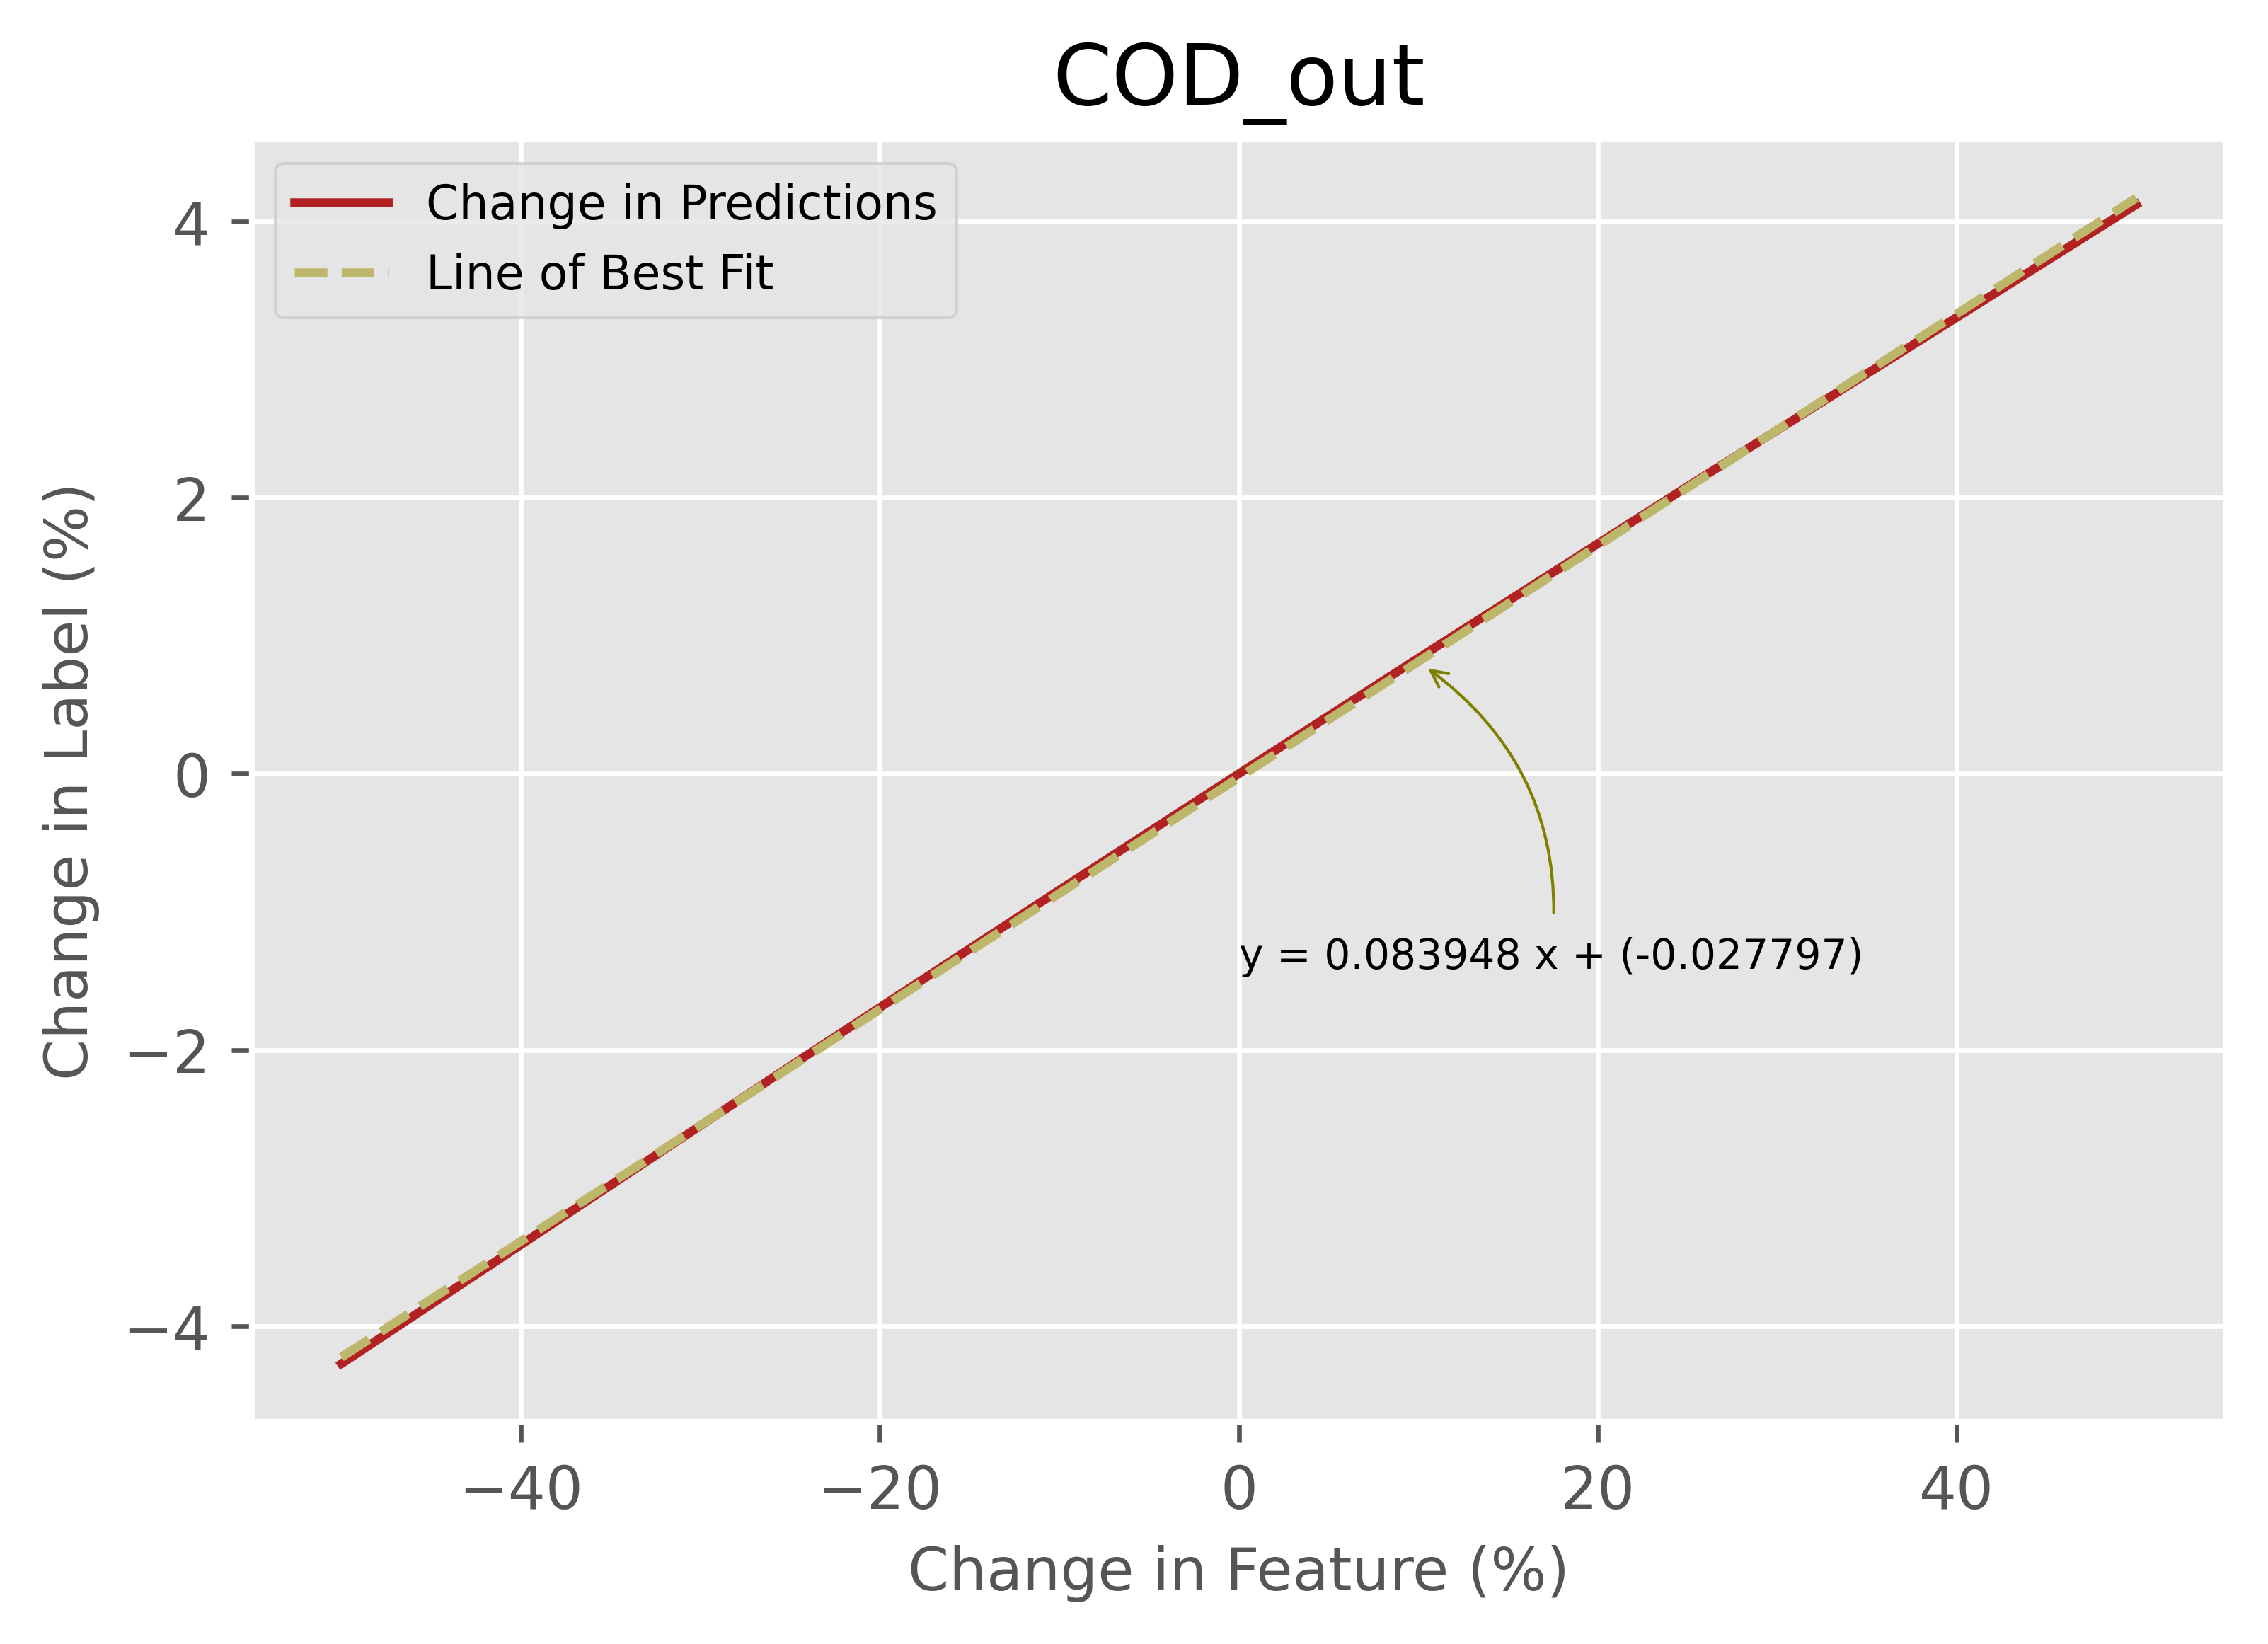

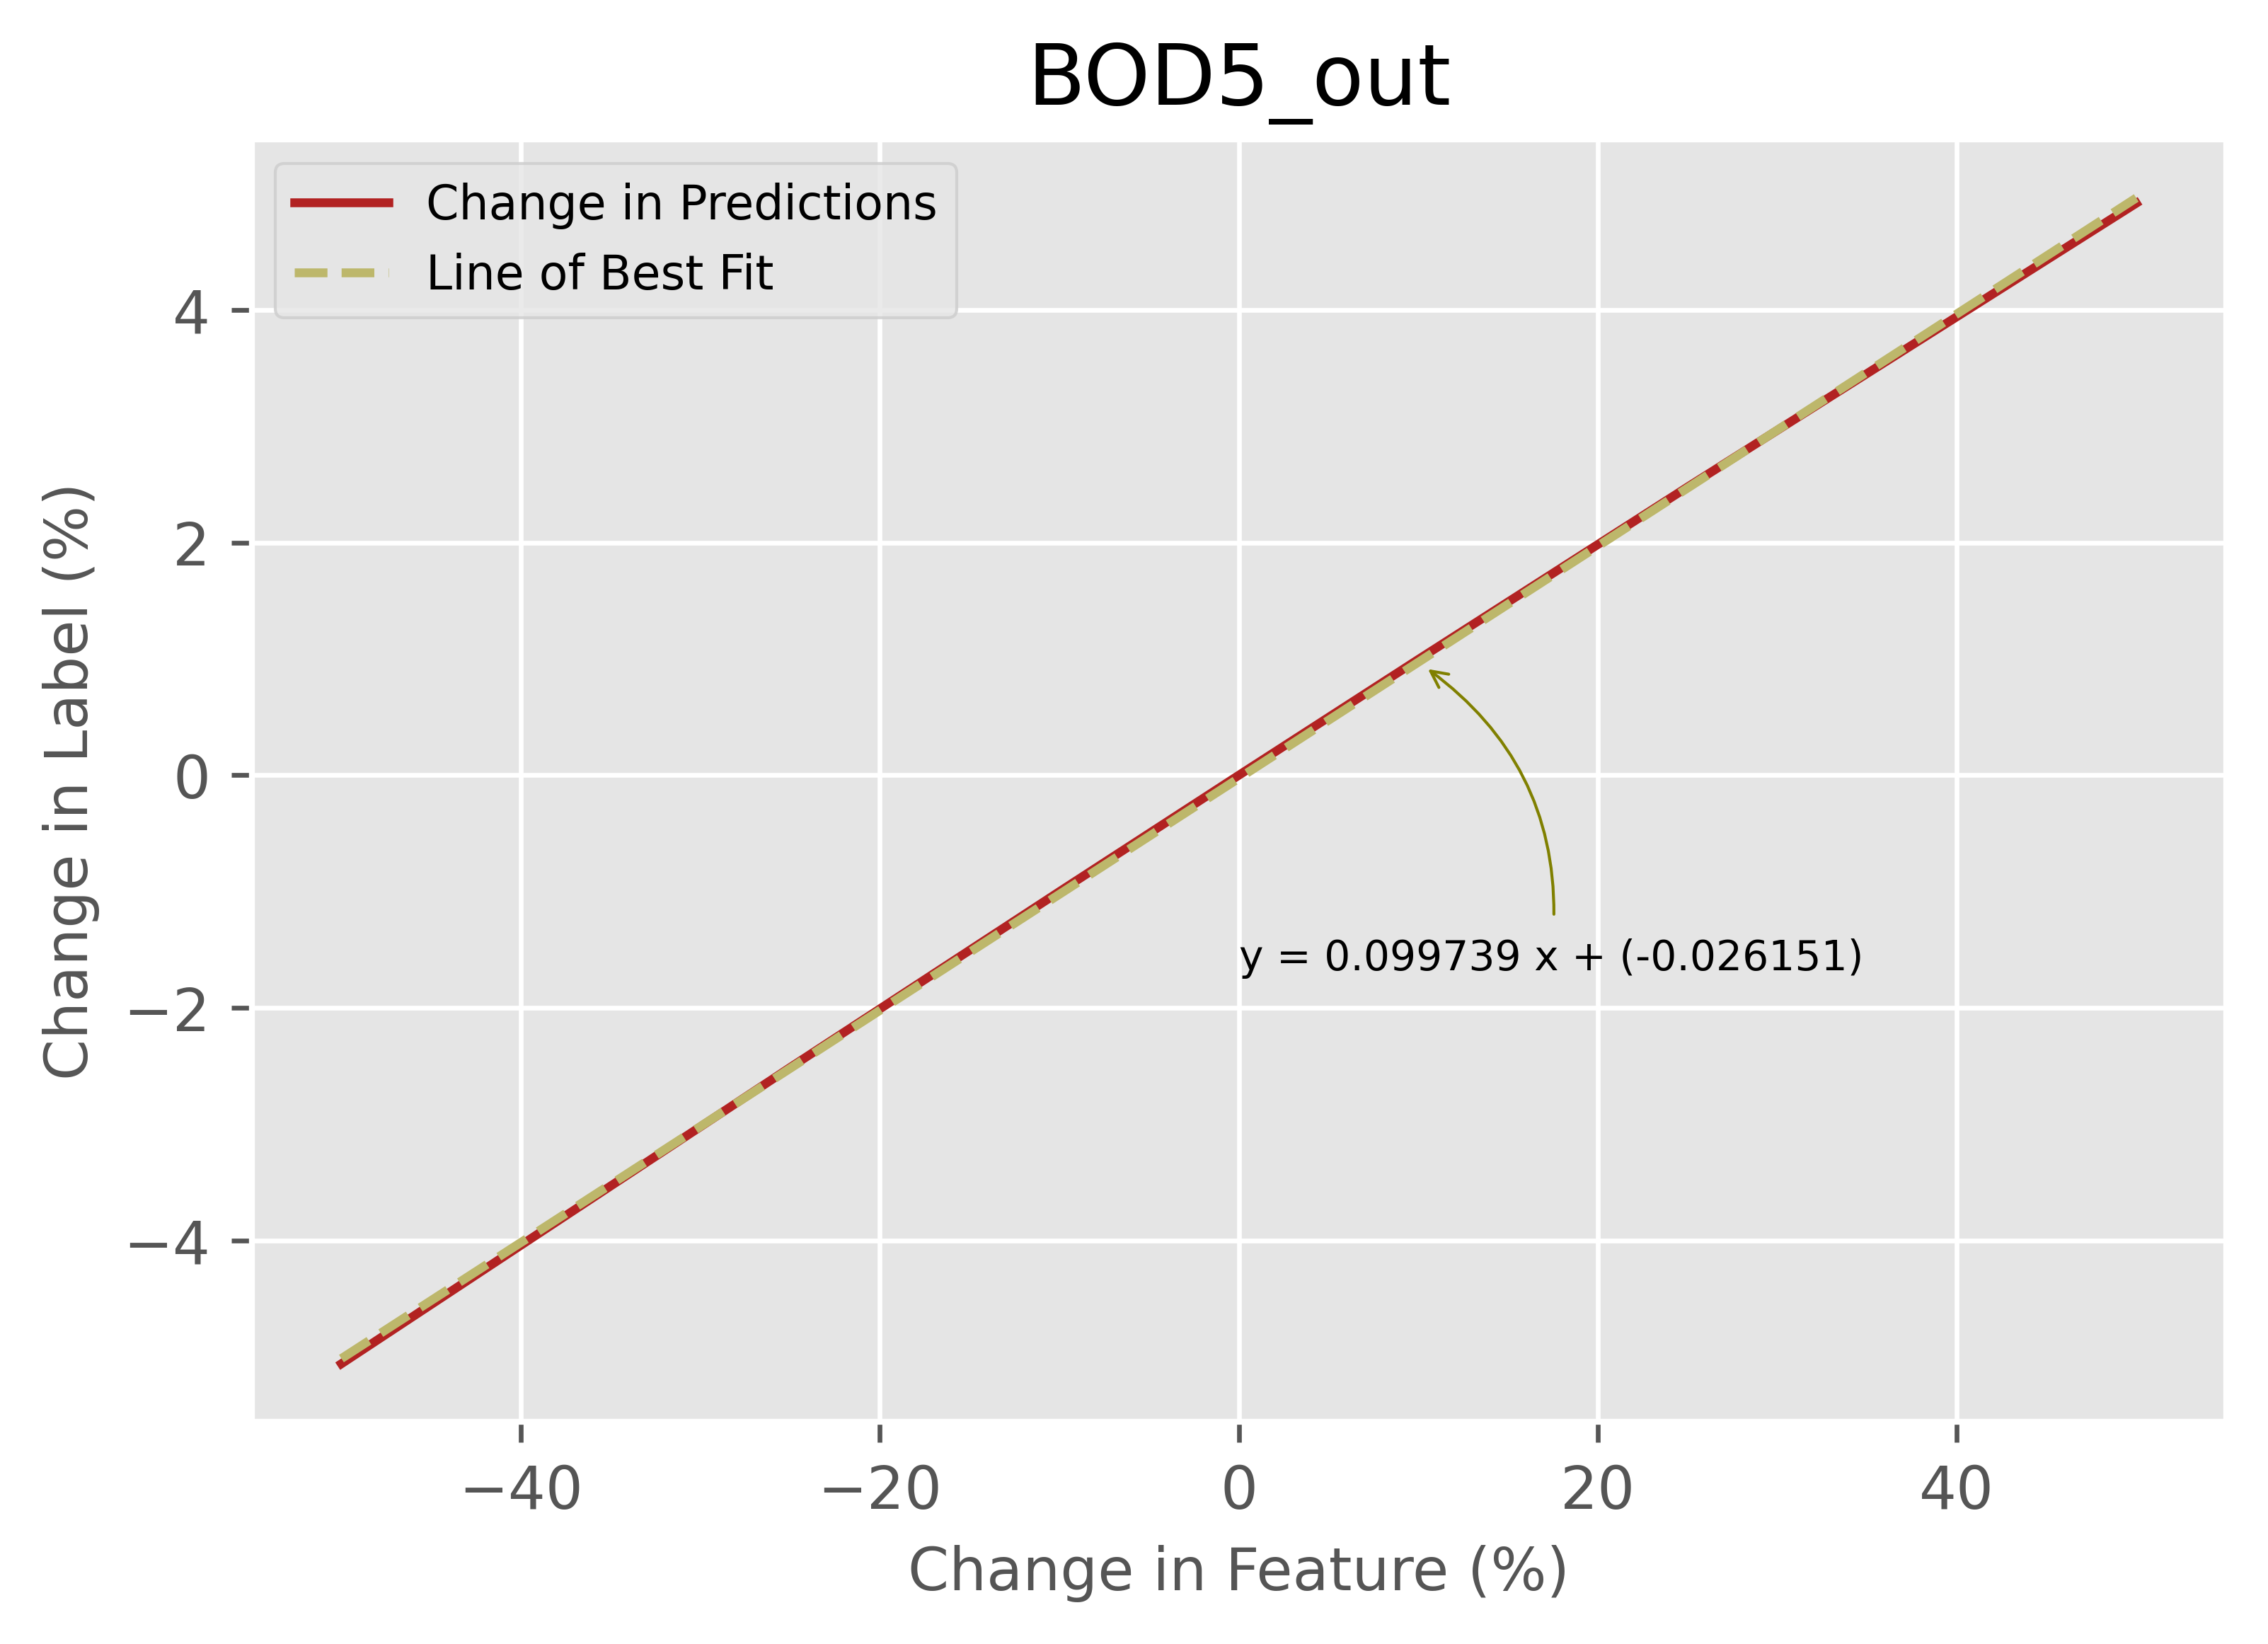

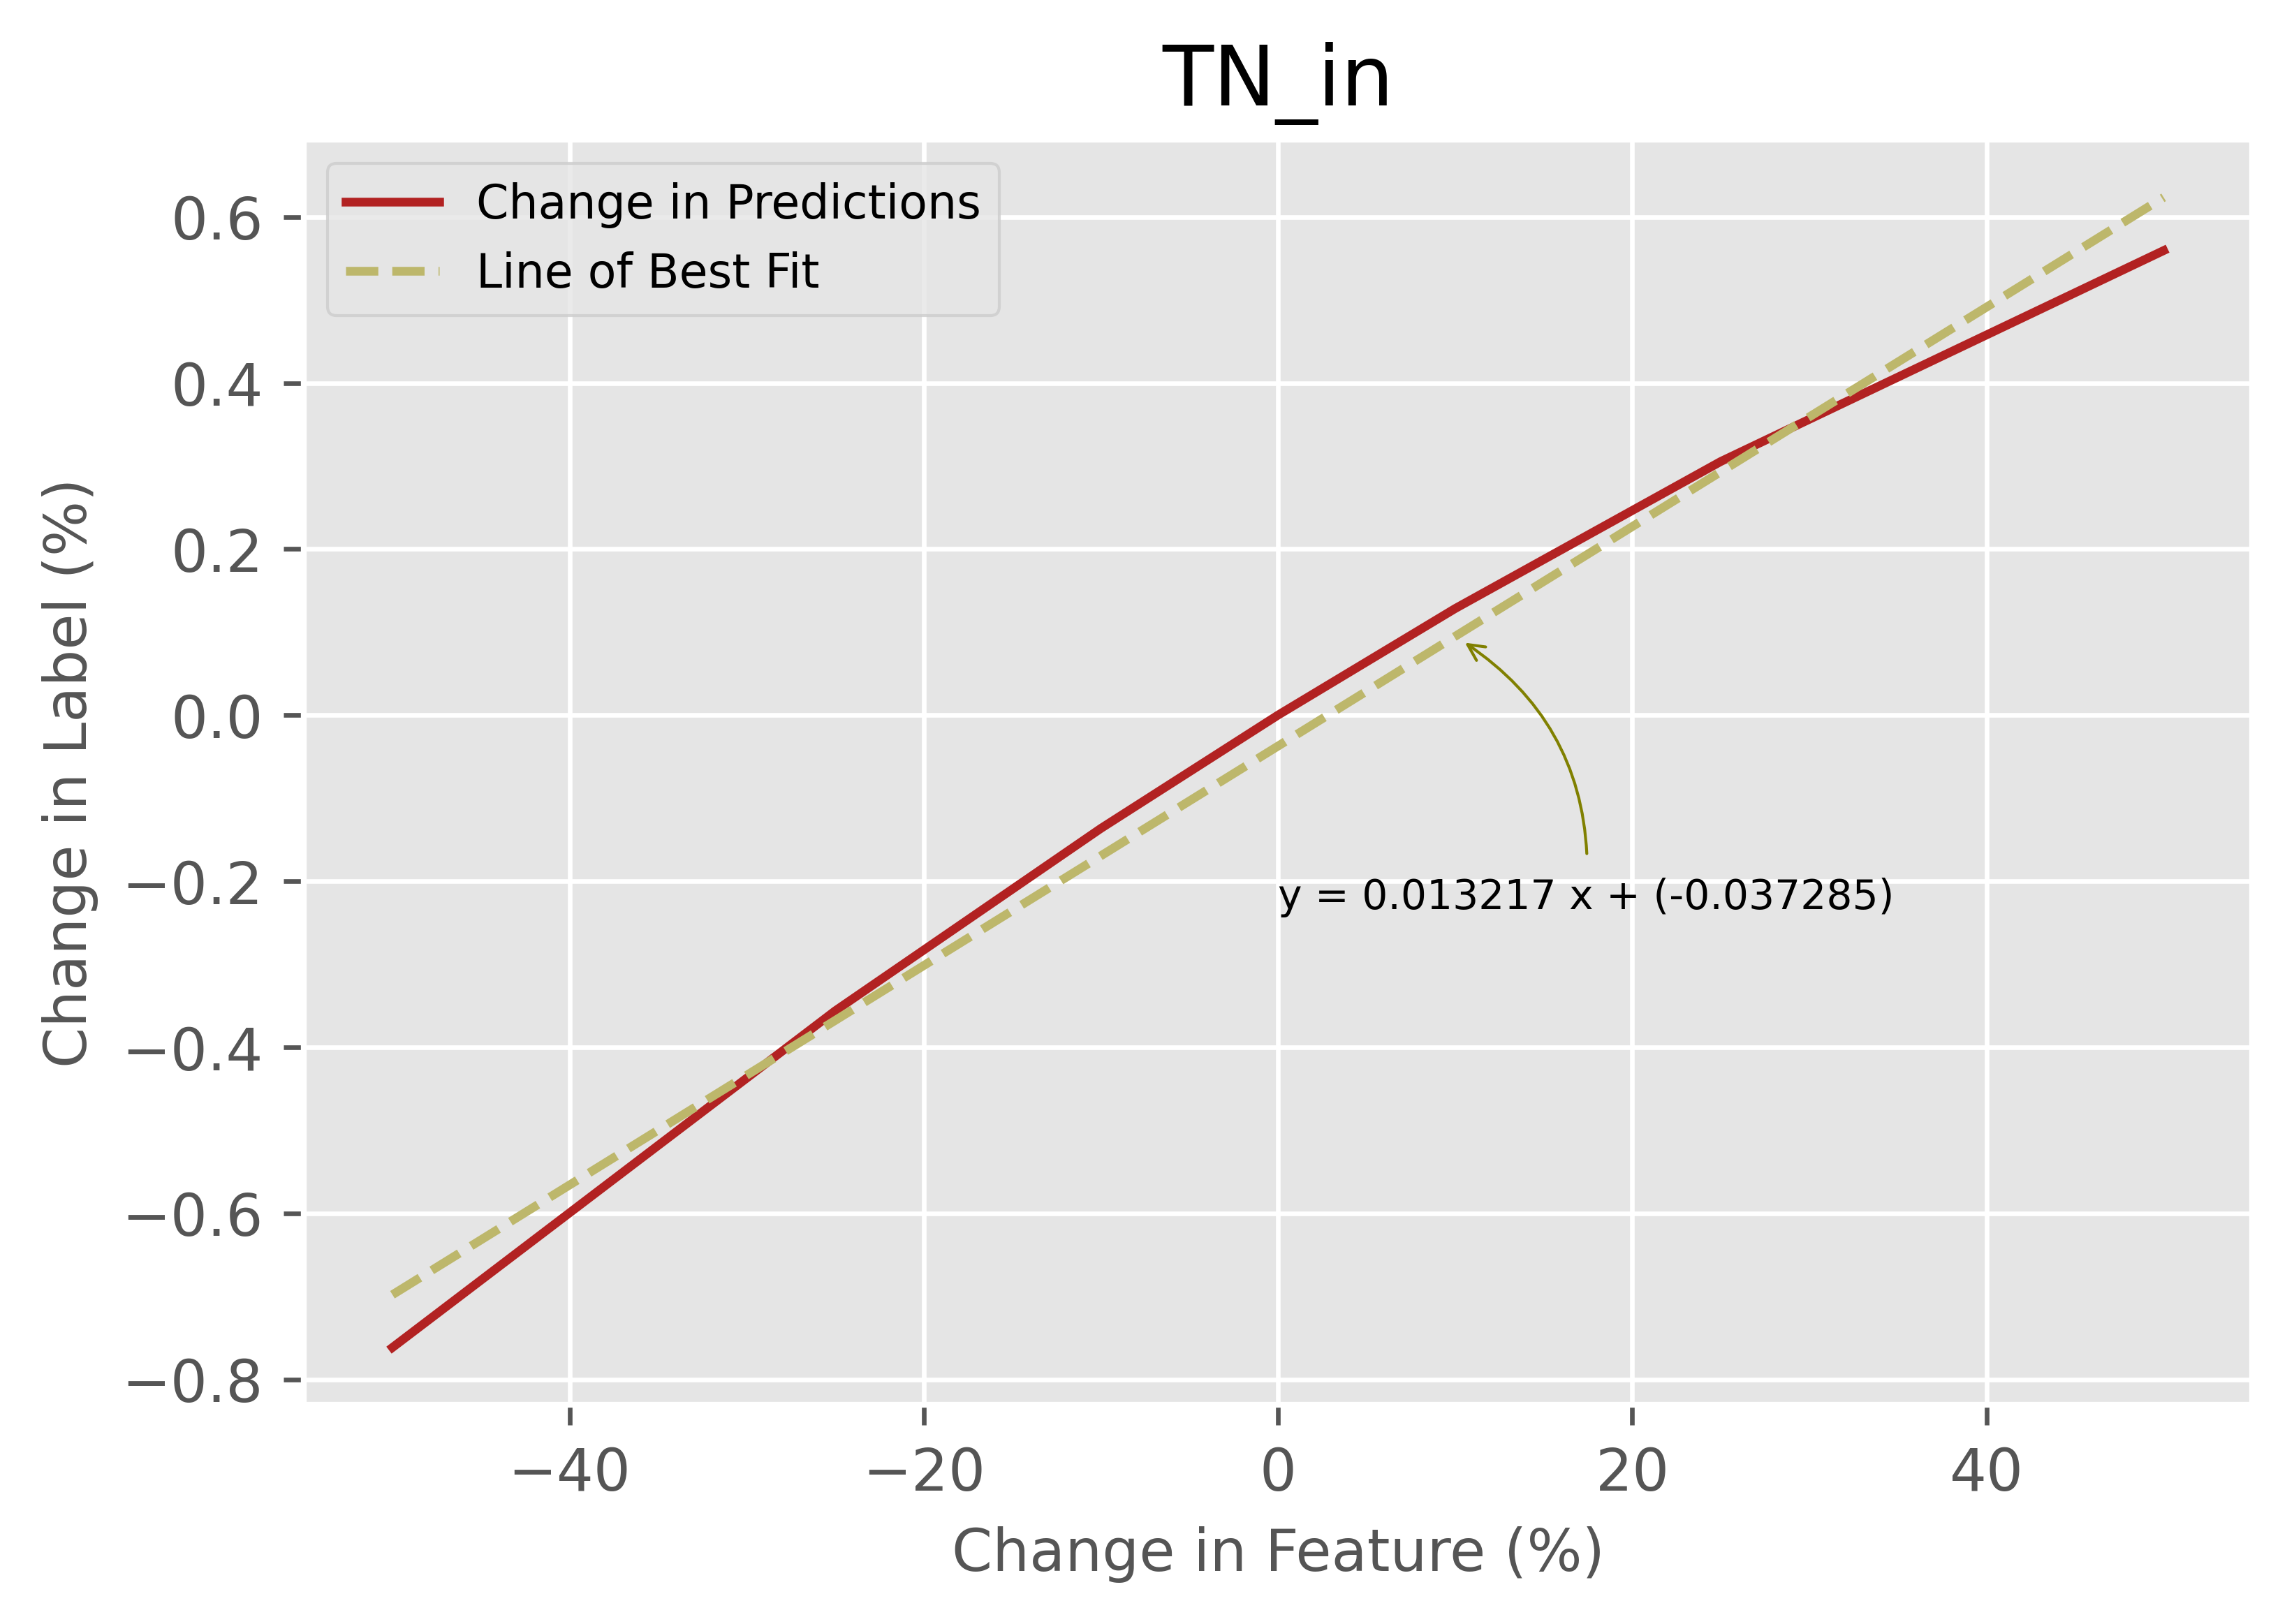

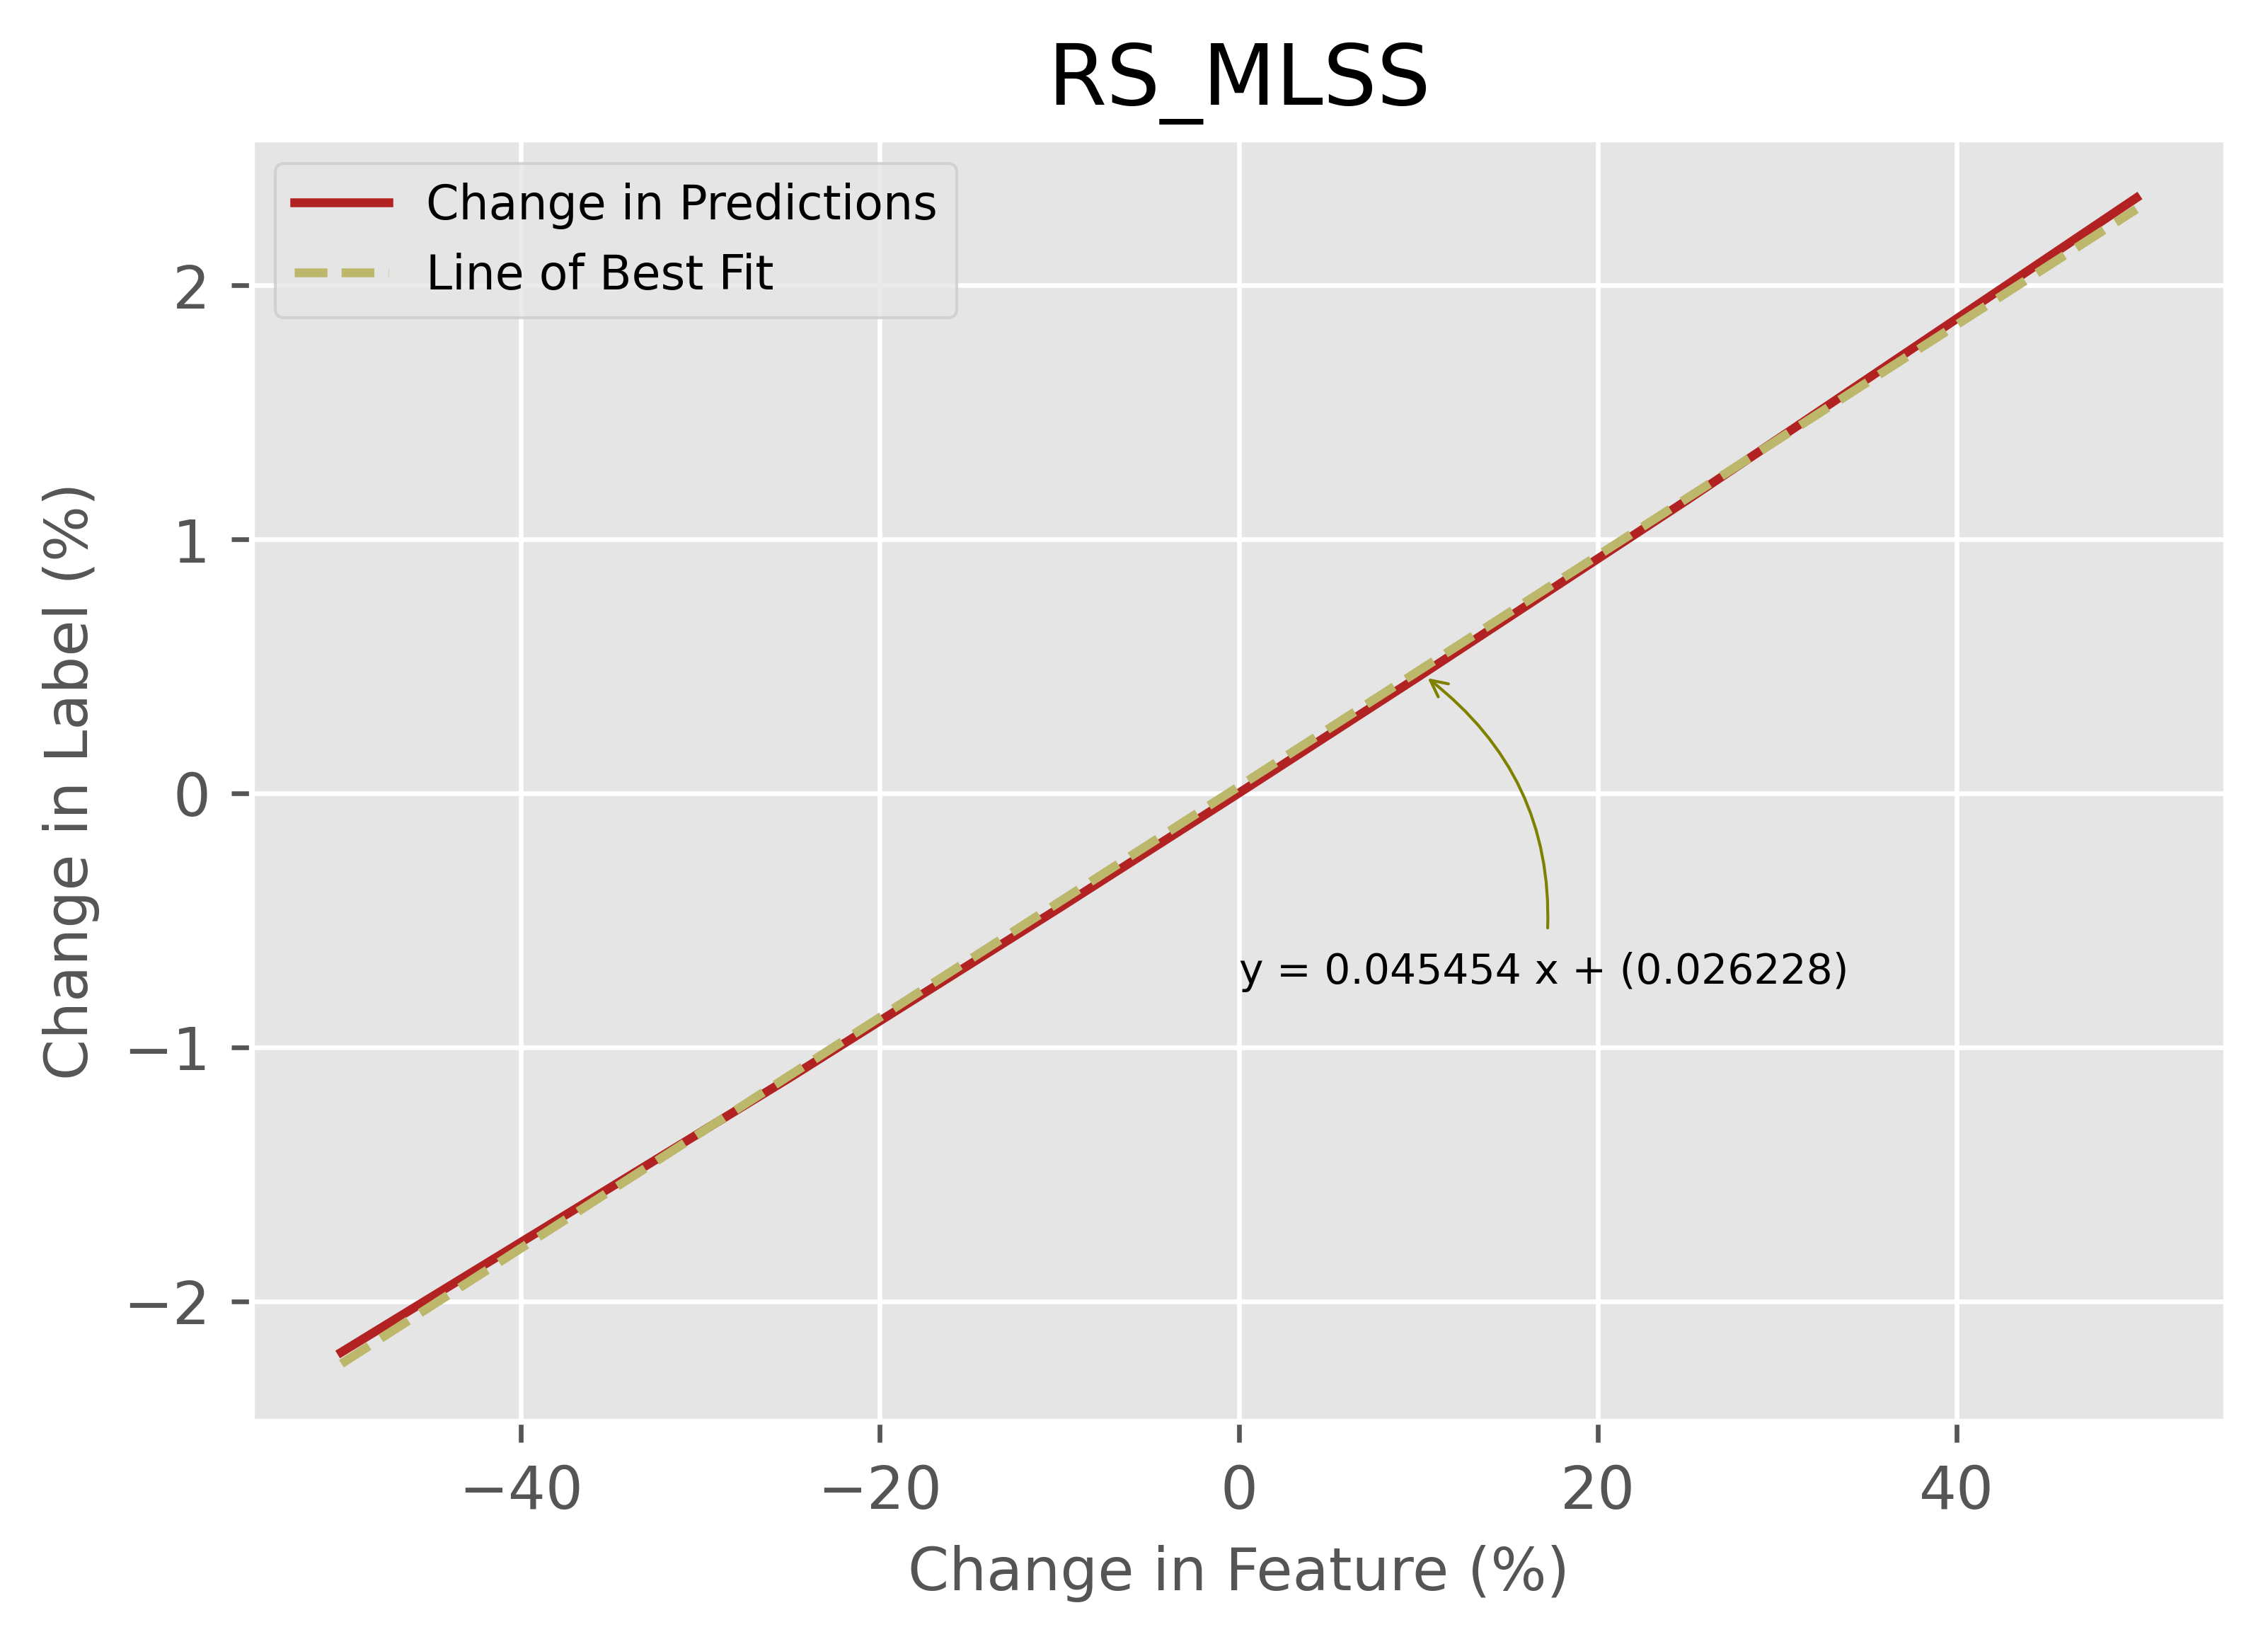

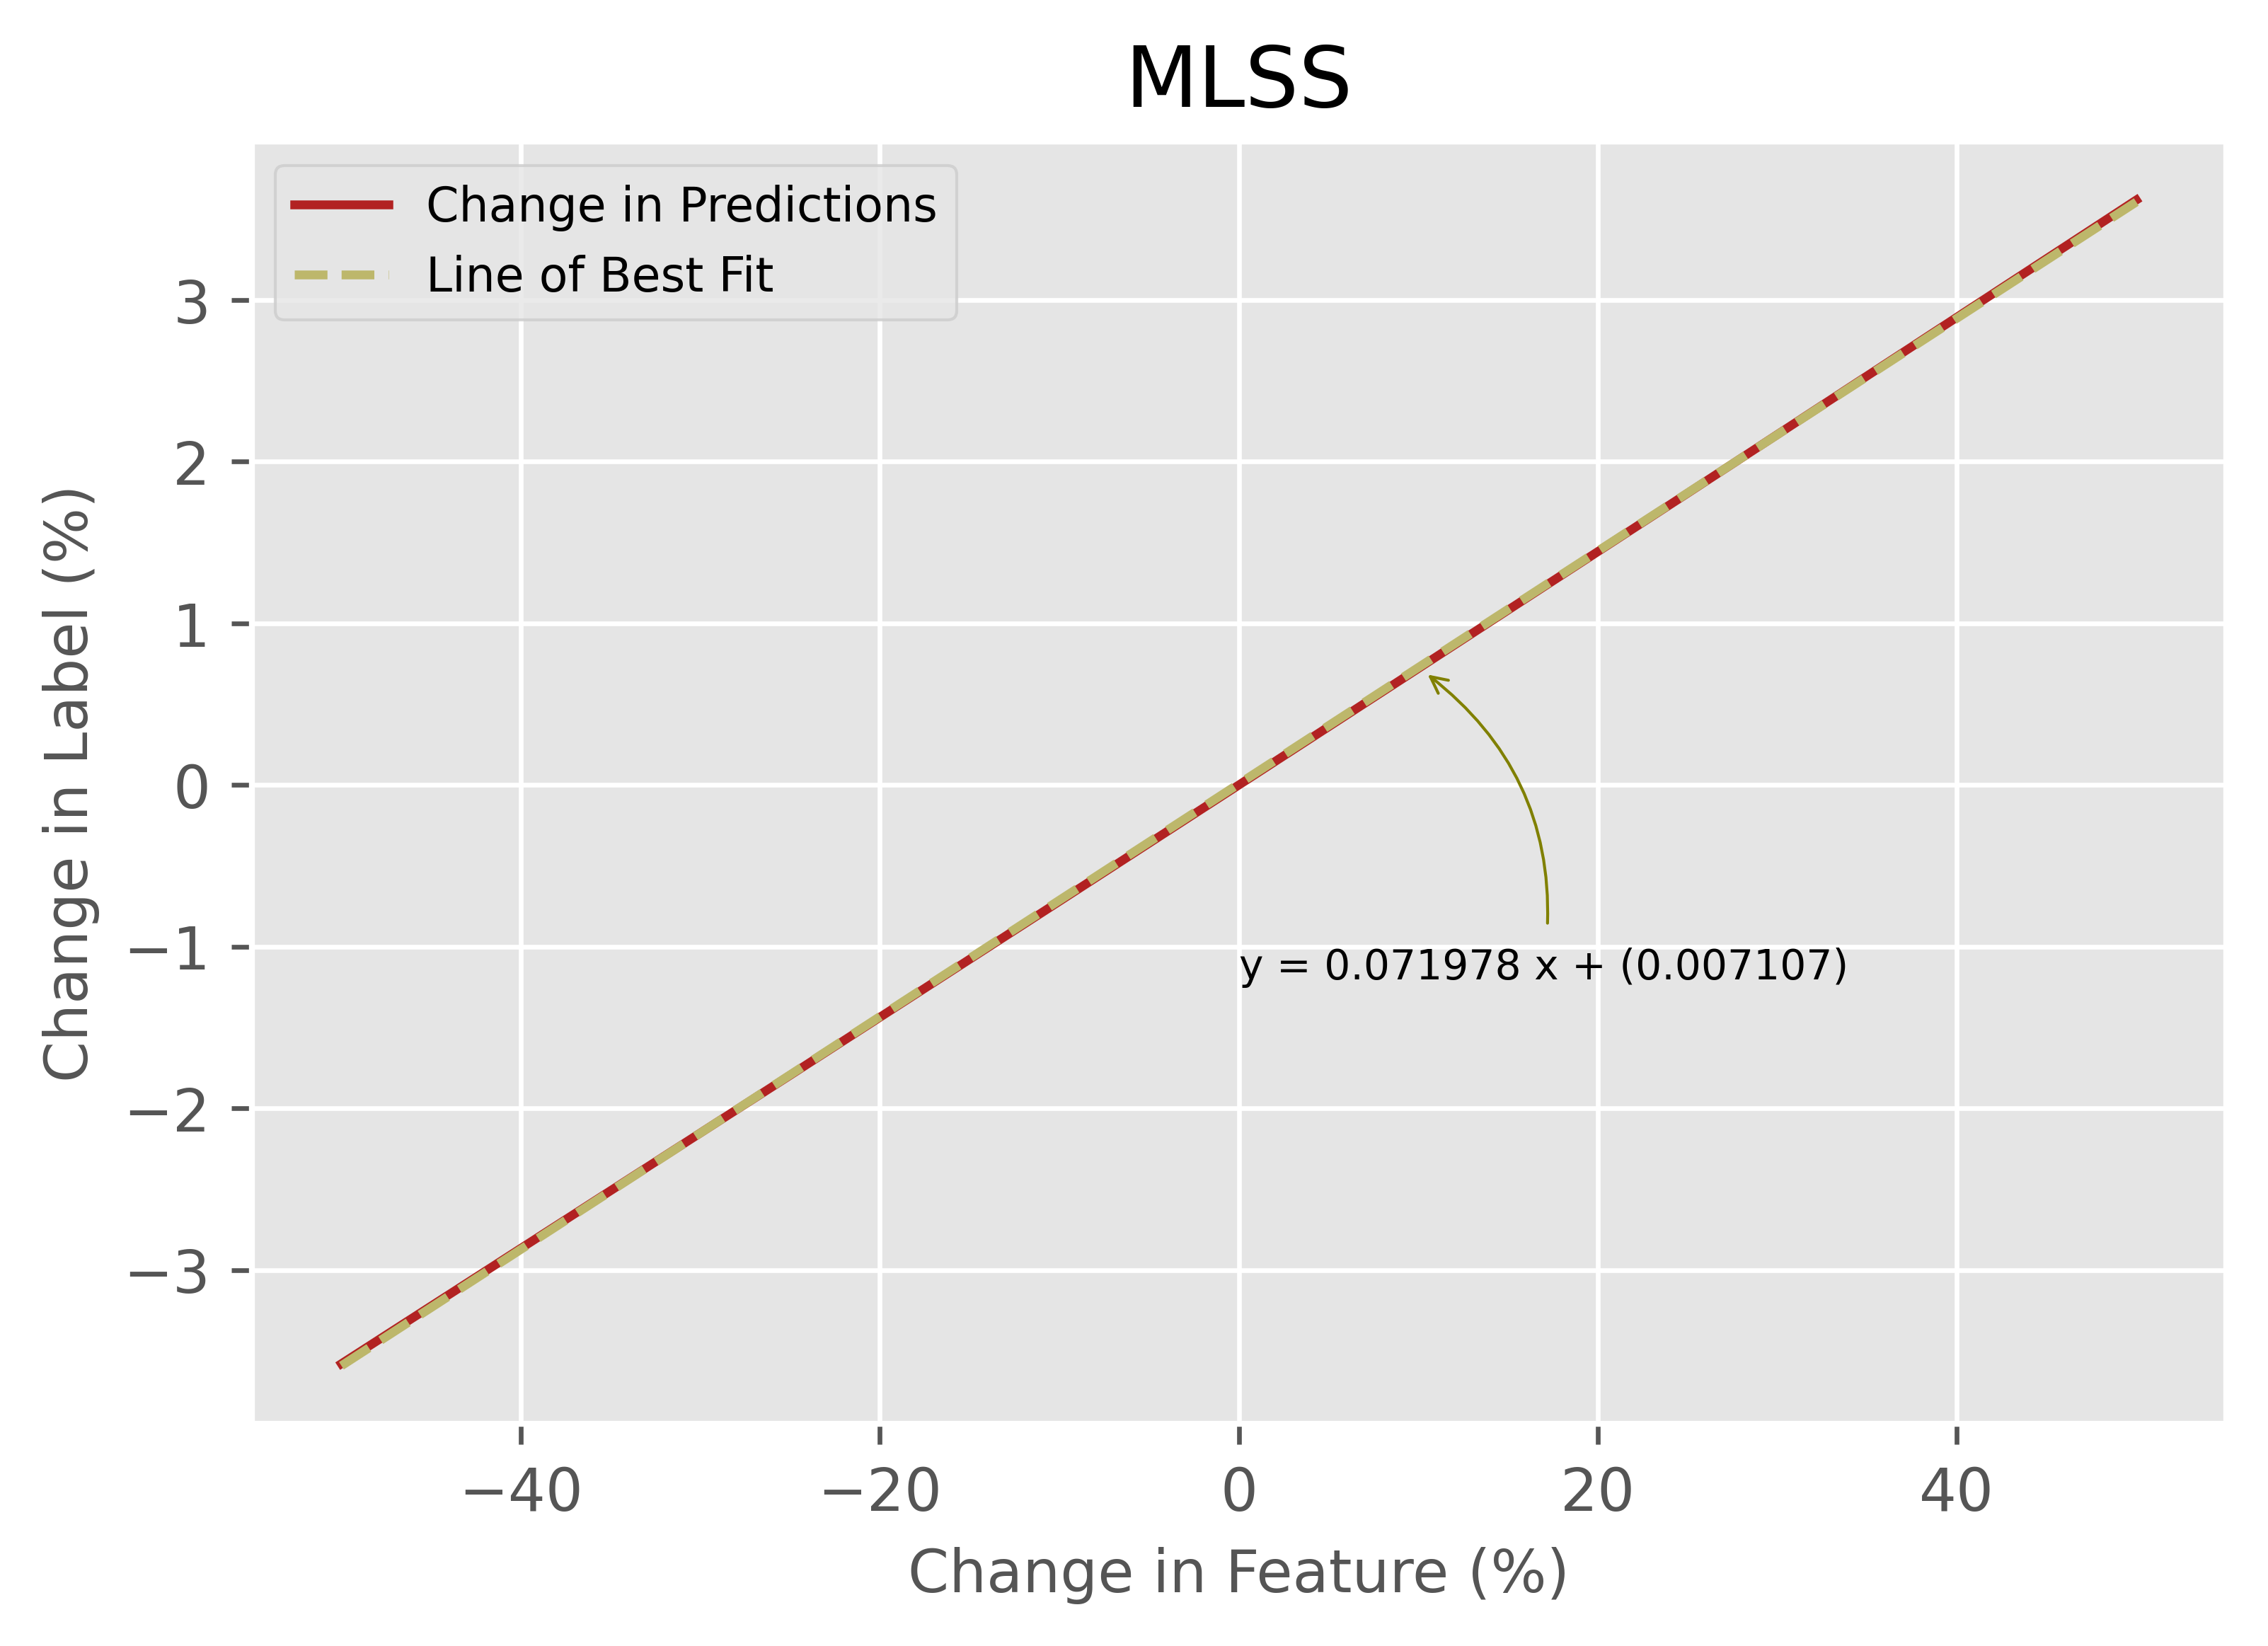

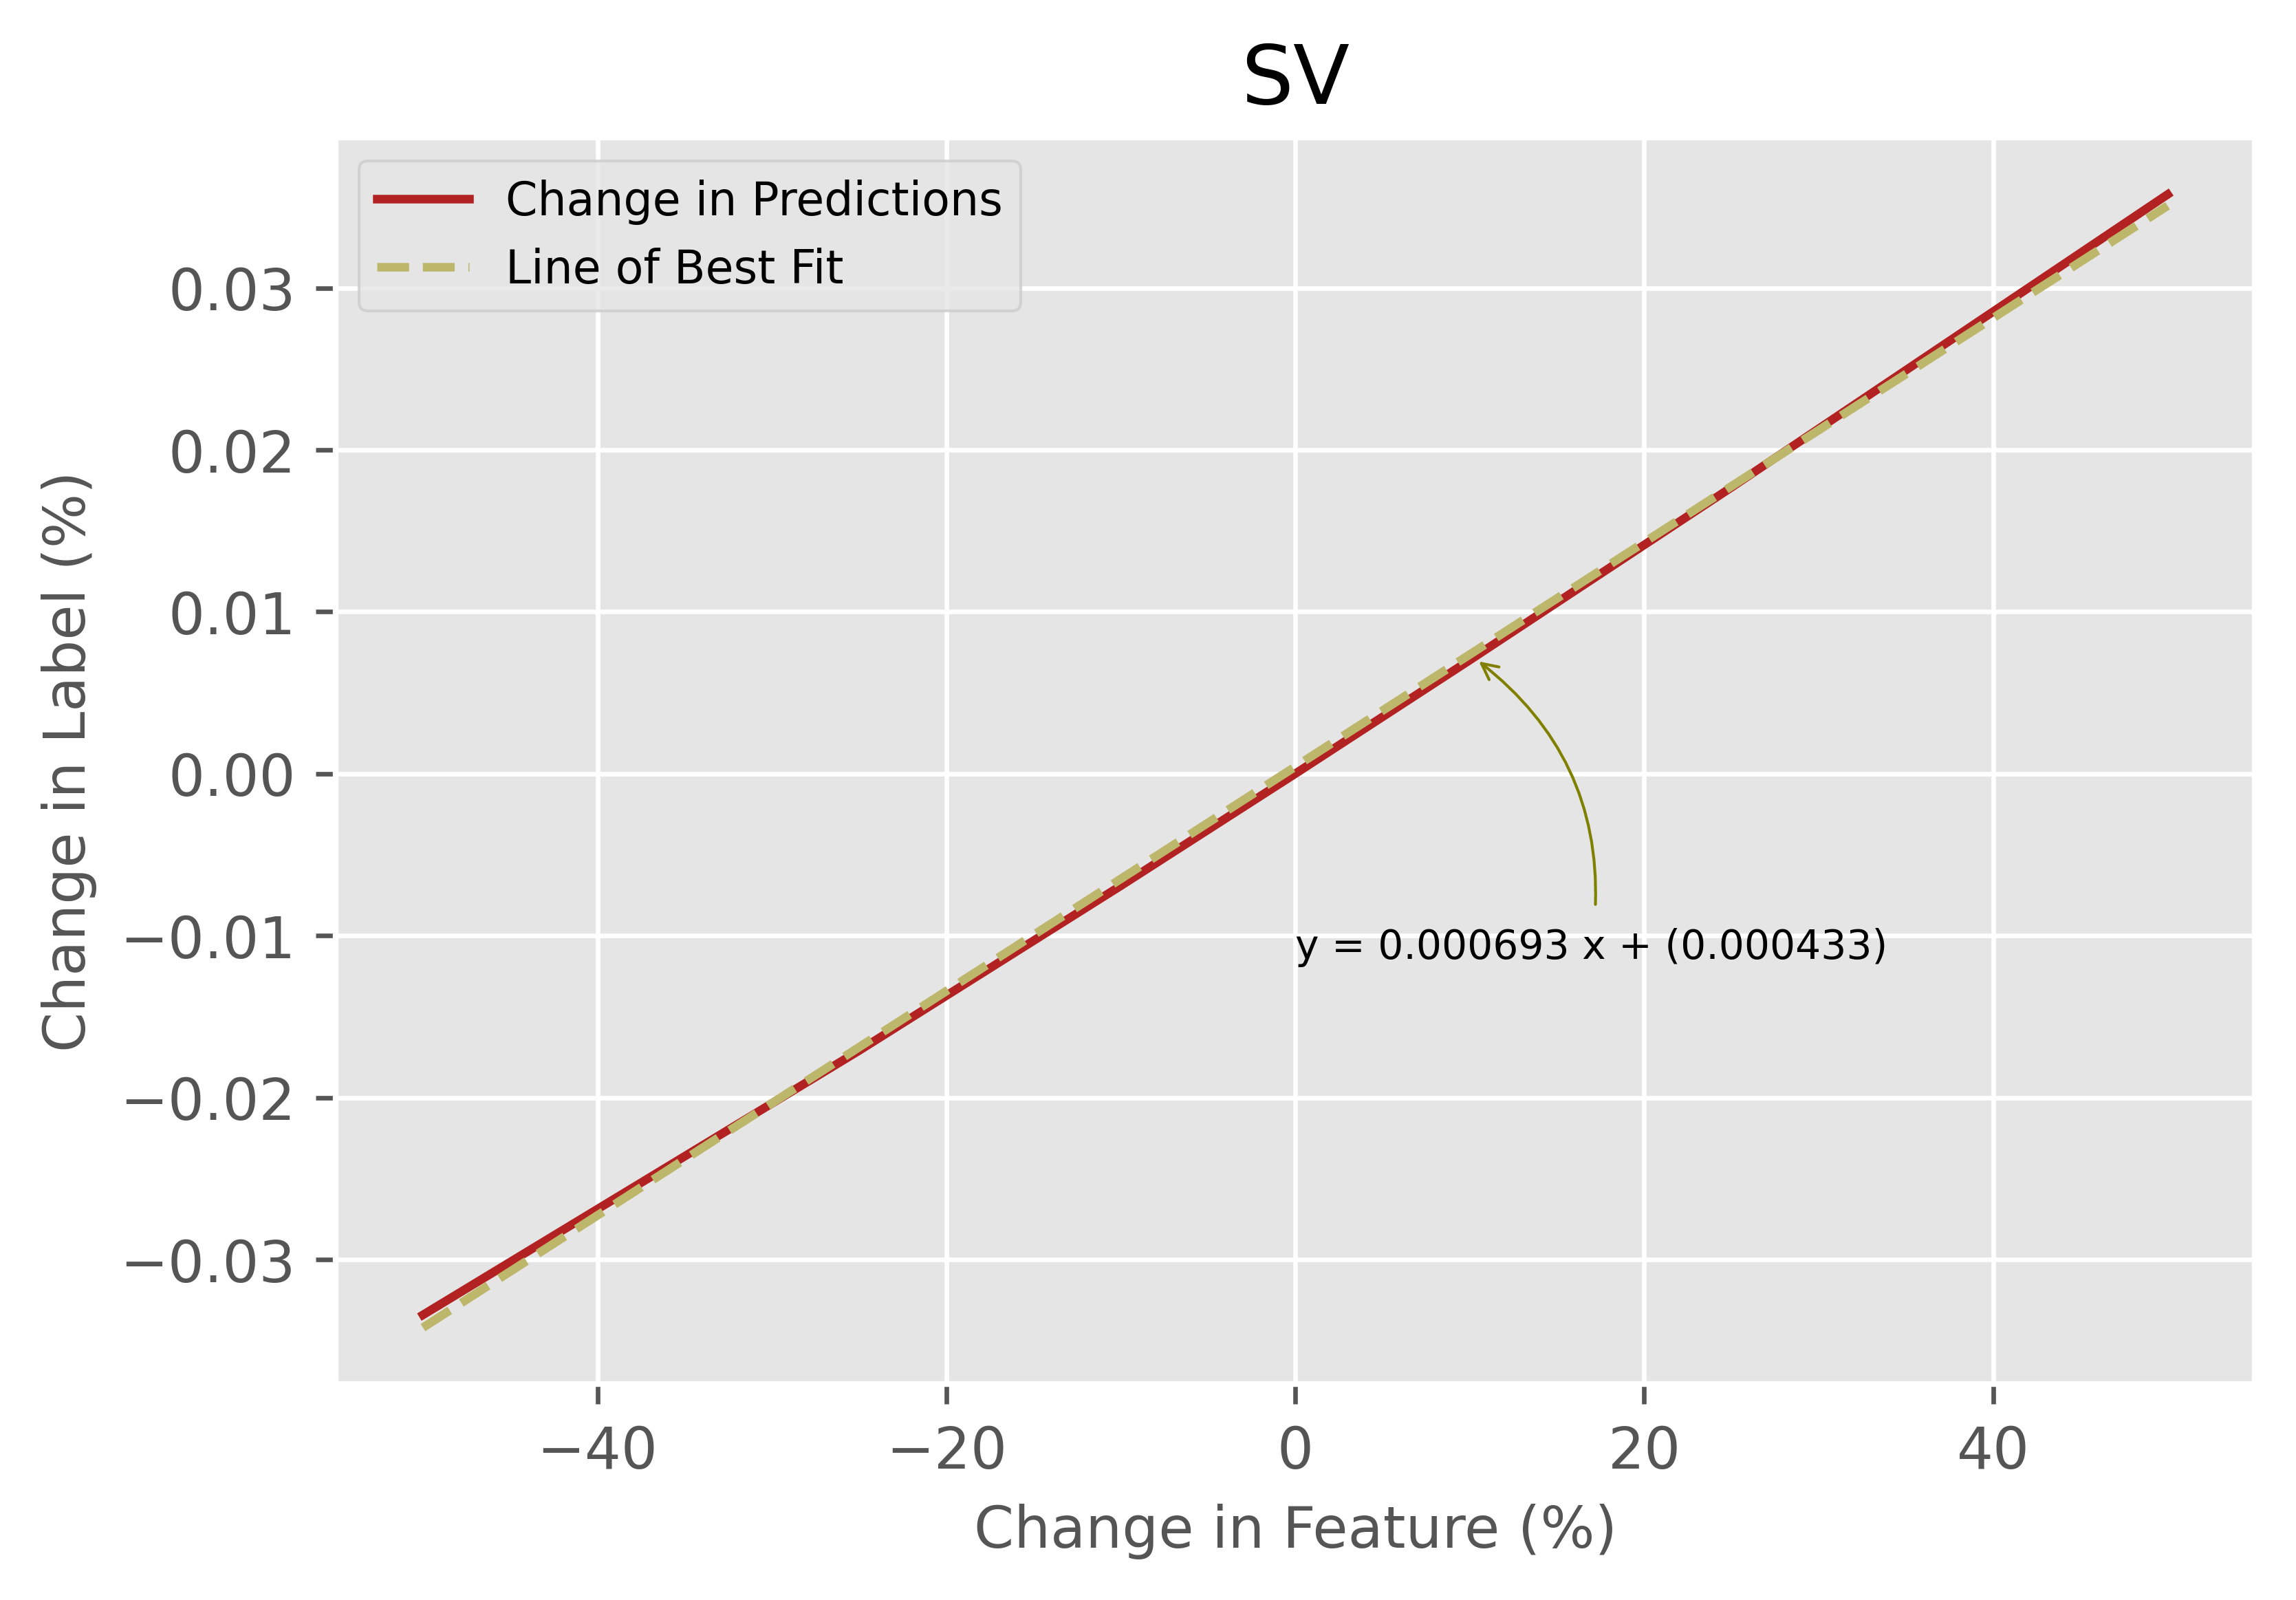

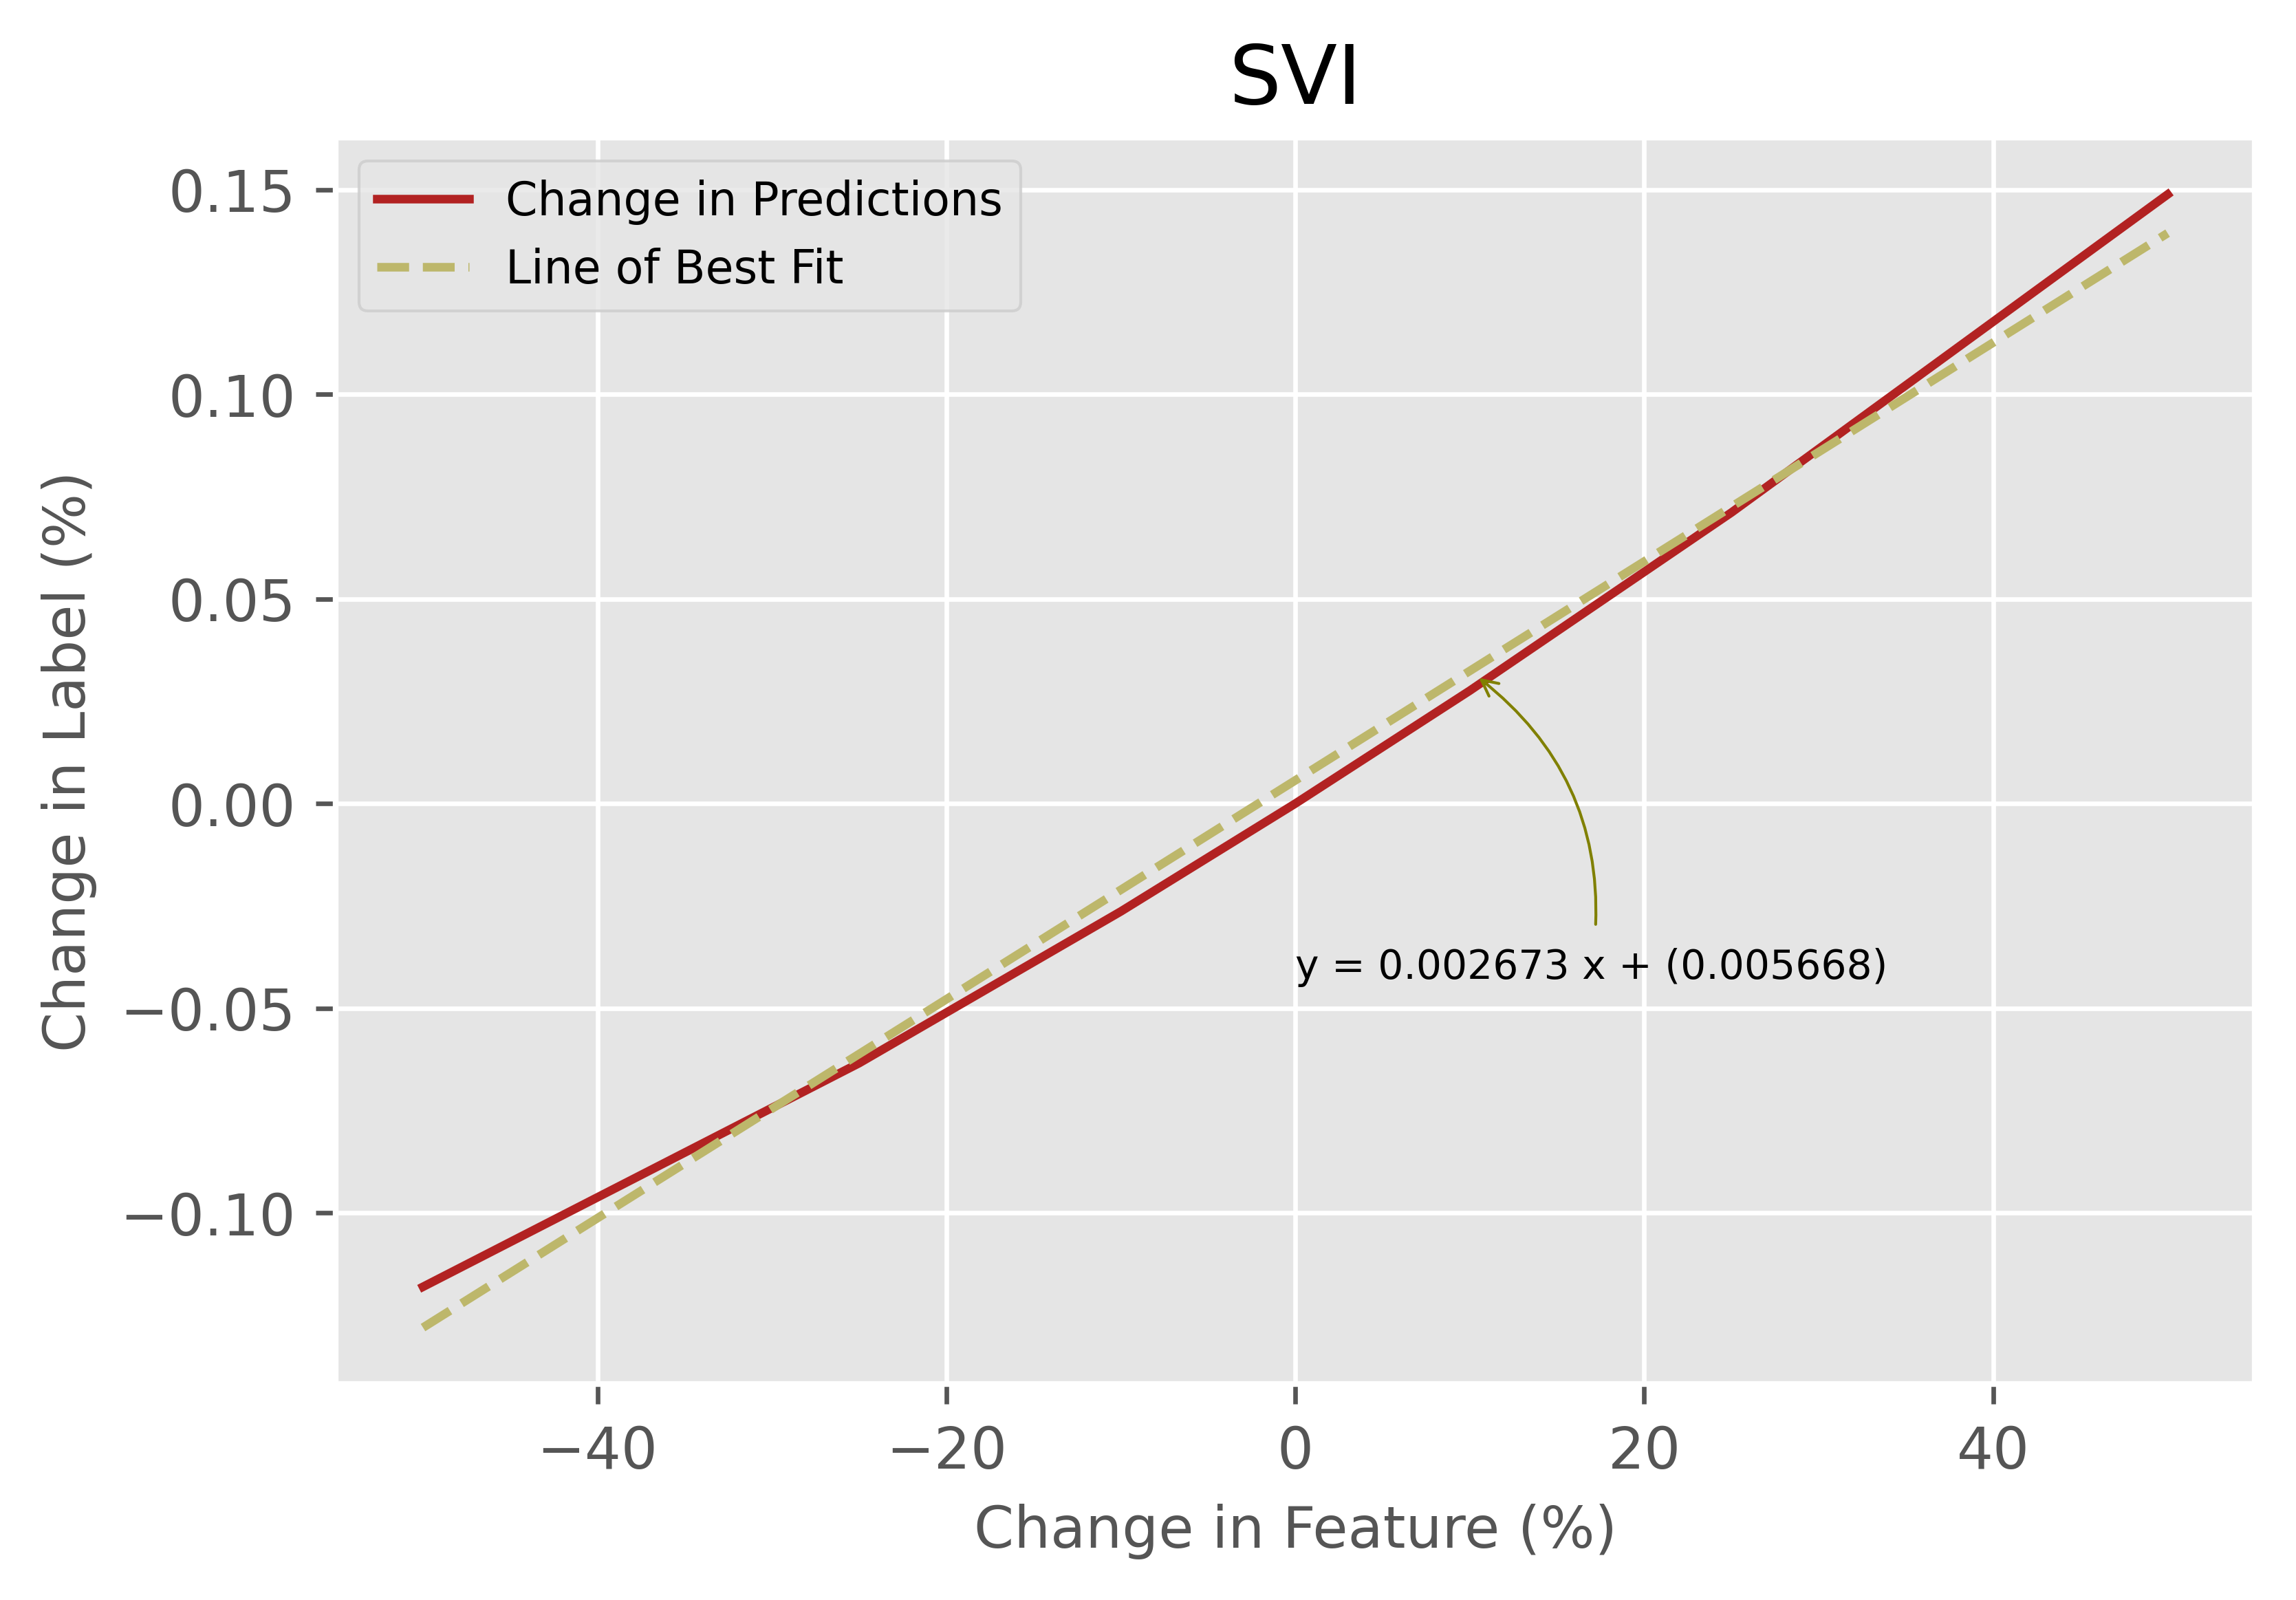

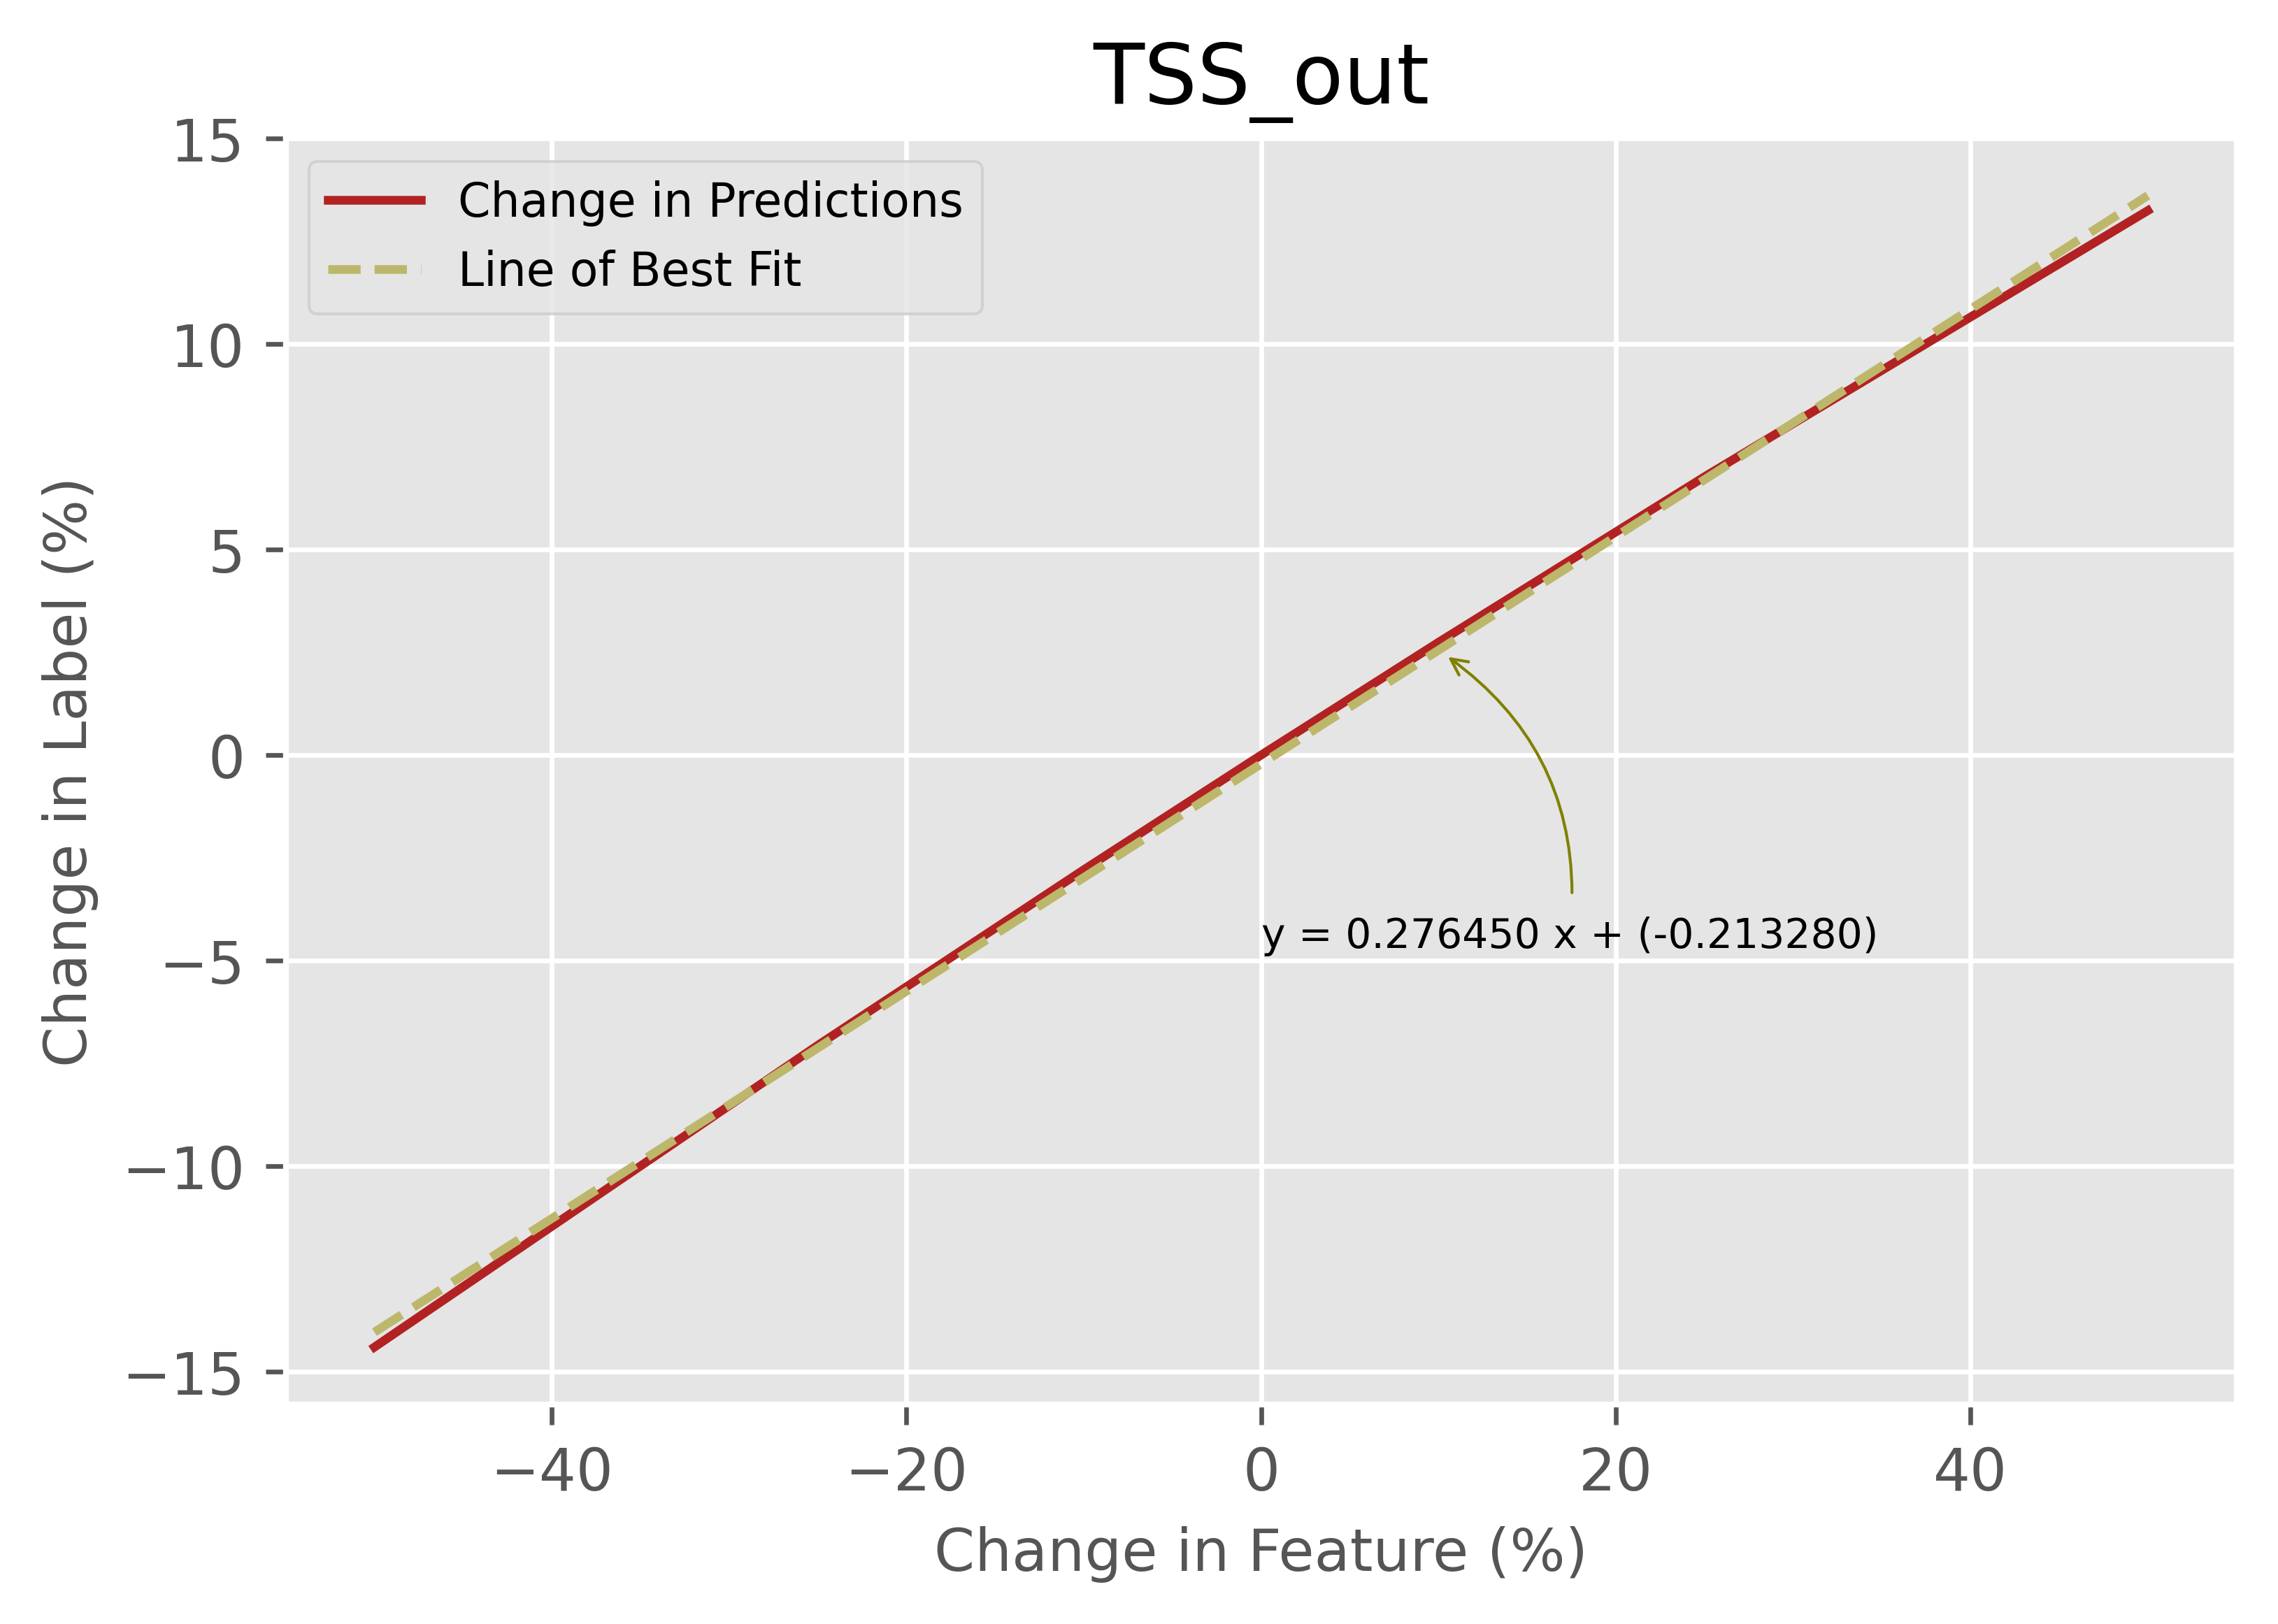

In [ ]:
for ind in range(TSS_SA_Avg.shape[0]):
    Title = df.columns[ind]
    X = np.array([-50, -25, -10, 0, 10, 25, 50])
    Y = TSS_SA_Avg[ind]
    theta = np.polyfit(X, Y, 1)
    y = theta[1] + theta[0] * X
    file_directory = SA_Path + "/" + f"{ind}." + f"{Title}" + ".png"

    plt.figure(dpi=600)
    plt.style.use('ggplot')
    plt.title(f"{Title}")
    plt.plot(X, TSS_SA_Avg[ind], color='firebrick', linewidth=1.5, label="Change in Predictions")
    plt.plot(X, y, color='darkkhaki', linestyle='--', linewidth=1.5, label="Line of Best Fit")
    plt.annotate(f"y = {theta[0]:3f} x + ({theta[1]:3f})", xy=(X[4], y[4]), xytext=(0, y[0]/3), fontsize=7,
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.3", shrinkB=2, color='olive'))
    plt.legend(prop={'size': 8})
    plt.xlabel("Change in Feature (%)", fontsize=10)
    plt.ylabel("Change in Label (%)", fontsize=10)
    plt.savefig(file_directory)
    plt.show()

In [ ]:
PDF = pd.DataFrame(TSS_SA_Avg.T, columns=df.columns)
PDF

,COD_out,BOD5_out,TN_in,RS_MLSS,MLSS,SV,SVI,TSS_out
0,-4.272583,-5.057475,-0.761695,-2.201018,-3.579357,-0.033422,-0.118043,-14.399139
1,-2.117883,-2.511935,-0.356168,-1.119432,-1.795081,-0.017099,-0.063407,-7.058783
2,-0.842673,-1.000615,-0.136449,-0.452175,-0.719255,-0.006920,-0.026347,-2.789036
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.836634,0.994931,0.128335,0.457876,0.720800,0.007014,0.027579,2.742525
5,2.080146,2.476423,0.305490,1.155046,1.804729,0.017685,0.071103,6.768450
6,4.121777,4.915611,0.559494,2.343302,3.617917,0.035772,0.148791,13.243025
